## SCDV encoder for document mixture clustering

In [1]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

### Build SCDV

In [2]:
import os
import random
import dill
import numpy as np

from helpers import Indexer, batch
from itertools import chain, product
from collections import defaultdict

In [10]:
nyt_code_dir = "/work/04233/sw33286/AIDA-DATA/nyt_eng_salads_code/"
FILE_NAMES = os.listdir(nyt_code_dir)

# info_path = "/work/04233/sw33286/AIDA-DATA/nyt_eng_salads_info/indexer_word2emb_100k.p"
# indexer100k, word2emb100k = dill.load(open(info_path, 'rb'))

In [3]:
# Document reader for nyt_story_salad dataset.

import os
import dill
from itertools import chain

class NytDocGetter:
    
    def __init__(self, doc_dir):
        self.doc_dir = doc_dir
        self.filenames = os.listdir(self.doc_dir)
        self.curr_idx = 0
        self.size = len(self.filenames)
    
    def reset(self):
        self.curr_idx = 0
        
    def has_next(self):
        return self.curr_idx < self.size
    
    def get_doc(self):
        if self.has_next():
            filename = self.filenames[self.curr_idx]
            self.curr_idx += 1
            _, _, salad_code = dill.load(open(self.doc_dir+filename, 'rb'))
            return list(chain.from_iterable(salad_code))
        else:
            raise EOFError("End of document list. Please reset document getter.")

In [4]:
import time
import numpy as np
from collections import Counter
from sklearn.mixture import GMM

class SCDV:
    
    def __init__(self, doc_getter, indexer, word2emb,
                       n_gmm_comps=100, n_gmm_iters=50, sparse_p=0.04): # best hyperparams in original paper.
        self.doc_getter = doc_getter
        self.indexer = indexer
        self.vocab_size = len(self.indexer)
        self.word2emb = word2emb
        self.wordemb_dim = len(self.word2emb.get('UNK',self.word2emb['the']))
        self.n_gmm_comps = n_gmm_comps
        self.n_gmm_iters = n_gmm_iters
        self.p = sparse_p
        self.error_fileids = []
        
    def train(self):
        print('... Computing word counts', end=' ')
        start = time.time()
        self._compute_word_count()
        print('(time elapsed = {})'.format(time.time()-start))
        print('... Computing word idfs', end=' ')
        start = time.time()
        self._compute_word_idf()
        print('(time elapsed = {})'.format(time.time()-start))
        print('... Performing GMM clustering', end=' ')
        start = time.time()
        self._gmm_cluster()
        print('(time elapsed = {})'.format(time.time()-start))
        print('... Computing SCDV word representations', end=' ')
        start = time.time()
        self._compute_scdv()
        print('(time elapsed = {})'.format(time.time()-start))
        print('Ready to encode!')
        
    def _compute_word_count(self):
        self.wordcode2count = Counter()
        counter = 0
        while self.doc_getter.has_next():
            try:
                for wordcode in self.doc_getter.get_doc():
                    self.wordcode2count[wordcode] += 1
            except:
                self.error_fileids.append(counter)
            counter += 1
        self.doc_getter.reset()
    
    def _compute_word_idf(self):
        self.wordcode2idf = dict()
        num_docs = self.doc_getter.size
        for wordcode,count in self.wordcode2count.items():
            self.wordcode2idf[wordcode] = np.log(num_docs/count)
    
    def _get_word_emb_mat(self):
        wordemb_mat = []
        for i in range(len(self.indexer)):
            wordemb_mat.append(self.word2emb[self.indexer.get_object(i)])
        return np.array(wordemb_mat)
    
    def _gmm_cluster(self):
        gmm = GMM(n_components=self.n_gmm_comps,covariance_type='tied',init_params='kmeans',n_iter=self.n_gmm_iters)
        wordemb_mat = self._get_word_emb_mat()
        gmm.fit(wordemb_mat)
        self.pred_clus = gmm.predict(wordemb_mat)
        self.pred_prob = gmm.predict_proba(wordemb_mat)
        self._get_clus_given_wordcode = lambda wordcode: self.pred_clus[wordcode]
        self._get_prob_given_wordcode = lambda wordcode: self.pred_prob[wordcode]
    
    def _compute_scdv(self):
        # Compute unsparse word representations.
        self.wordcode2unsp_emb = dict()
        for word,emb in self.word2emb.items():
            wordcode = self.indexer.get_index(word,add=False)
            wcv = np.array([])
            for prob in self._get_prob_given_wordcode(wordcode):
                wcv = np.concatenate([wcv,emb*prob])
            wtv = self.wordcode2idf[wordcode] * wcv
            self.wordcode2unsp_emb[wordcode] = wtv # correction made here
        # Compute sparse word representations.
        dv_min_sum = dv_max_sum = 0
        counter = 0
        while self.doc_getter.has_next():
            dv = np.zeros(self.n_gmm_comps*self.wordemb_dim)
            try:
                for wordcode in self.doc_getter.get_doc():
                    if wordcode>=0 or wordcode<self.vocab_size: # within vocab range.
                        dv += self.wordcode2unsp_emb[wordcode]
                dv_min_sum += dv.min()
                dv_max_sum += dv.max()
            except:
                pass # error already logged in word counting.
            counter += 1
        self.doc_getter.reset()
        a_min = dv_min_sum / self.doc_getter.size
        a_max = dv_max_sum / self.doc_getter.size
        t = (np.abs(a_min) + np.abs(a_max)) / 2
        self.epsilon = (self.p/100) * t # threshold of sparse cut.
        
    def _make_sparse(self, doc_vec):
        return np.array([a_i if np.abs(a_i)>=self.epsilon else 0.0 for a_i in doc_vec])

    def get_doc_vec(self, doc, encode=True, sparse=True):
        if encode:
            doccode = [self.indexer.get_index(word) if self.indexer.contains(word) else self.indexer.get_index('UNK')
                       for word in doc]
        else:
            doccode = doc
        dv = np.zeros(self.n_gmm_comps*self.wordemb_dim)
        for wordcode in doccode:
            dv += self.wordcode2unsp_emb[wordcode]
        if sparse:
            return self._make_sparse(dv)
        return dv  

In [112]:
scdv = SCDV(NytDocGetter(nyt_code_dir), indexer100k, word2emb100k)

In [113]:
%%time

scdv.train()

... Computing word counts (time elapsed = 7523.718257427216)
... Computing word idfs (time elapsed = 0.16323351860046387)
... Performing GMM clustering (time elapsed = 3824.9352333545685)
... Computing SCDV word representations (time elapsed = 15092.62650513649)
Ready to encode!
CPU times: user 3h 9min 24s, sys: 16min 43s, total: 3h 26min 7s
Wall time: 7h 20min 41s


In [114]:
# save_path = "/work/04233/sw33286/AIDA-MODEL-SAVE/SCDV/nyt-v100k-gmm100comp-gmm50iter-p004.p"
# dill.dump(scdv, open(save_path, 'wb'))

### Evaluation

In [5]:
save_path = "/work/04233/sw33286/AIDA-MODEL-SAVE/SCDV/nyt-v100k-gmm100comp-gmm50iter-p004.p"
scdv = dill.load(open(save_path, 'rb'))

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

In [7]:
# Encoding with trained SCDV engine

def encode(doccode, scdv_coder):
    dv = np.zeros(scdv_coder.n_gmm_comps*scdv_coder.wordemb_dim)
    for wordcode in doccode:
        if wordcode>=0 and wordcode<=100001:
            dv += scdv_coder.wordcode2unsp_emb[wordcode]
    return dv

def to_code(doc, scdv_coder):
    return [scdv_coder.indexer.get_index(word,add=False) for word in doc if scdv_coder.indexer.contains(word)]

def to_sent(code, scdv_coder):
    return ' '.join([scdv_coder.indexer.get_object(c_) for c_ in code])

def get_eval_format(filename, scdv_coder):
    doc_a_code, doc_b_code, salad_code = dill.load(open(nyt_code_dir+filename, 'rb'))
    doc_mix, doc_labels = [], []
    for sentcode in salad_code:
        doc_mix.append(encode(sentcode, scdv_coder))
        if sentcode in doc_a_code:
            doc_labels.append(0)
        else:
            doc_labels.append(1)
    return np.array(doc_mix), np.array(doc_labels), salad_code

# Evaluation with class-based clustering accuracy (im Walde, 2009)

def clust_to_eval_input(pred_clust, true_clust):
    pred_ass2cls, pred_cls2ass = [], defaultdict(list)
    true_ass2cls, true_cls2ass = [], defaultdict(list)
    for item_id,(pred_ass,true_ass) in enumerate(zip(pred_clust,true_clust)):
        pred_ass2cls.append((item_id,pred_ass))
        true_ass2cls.append((item_id,true_ass))
        pred_cls2ass[pred_ass].append(item_id)
        true_cls2ass[true_ass].append(item_id)
    pred_ass2cls = dict(pred_ass2cls)
    true_ass2cls = dict(true_ass2cls)
    return pred_ass2cls, pred_cls2ass, true_ass2cls, true_cls2ass

def cb(source_a2c, source_c2a, target_a2c, target_c2a):
    prec_num = prec_denom = 0
    for _,ass in source_c2a.items():
        card_ass = len(ass)
        mem_cls = set()
        for elem in ass:
            for t_elem,cls in target_a2c.items():
                if elem==t_elem:
                    mem_cls.add(cls)
        prec_num += card_ass - len(mem_cls)
        prec_denom += card_ass - 1
    return prec_num / prec_denom   

def cb_prec(p_a2c, p_c2a, t_a2c, t_c2a):
    return cb(p_a2c, p_c2a, t_a2c, t_c2a)

def cb_rec(p_a2c, p_c2a, t_a2c, t_c2a):
    return cb(t_a2c, t_c2a, p_a2c, p_c2a)
    
def cb_f1(prec, rec):
    return (2*rec*prec) / (rec+prec)

# Random evaluation engine

def run_evaluation(eval_size=1000):
    verbose = 100
    precs, recs, f1s = [], [], []
    rand_filenames = np.random.choice(FILE_NAMES, size=eval_size, replace=False)
    for i,filename in enumerate(rand_filenames):
        doc_mix, doc_lbs, _ = get_eval_format(filename, scdv) # don't need original doc_mix here
        try:
            doc_mix_clust = linkage(doc_mix, method='average', metric='cosine')
        except:
            print('ERROR LOGGED @file {}'.format(filename))
        doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust')
        eval_input = clust_to_eval_input(doc_prd, doc_lbs)
        prec, rec = cb_prec(*eval_input), cb_rec(*eval_input)
        f1 = cb_f1(prec, rec)
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
        if i!=0 and i%verbose==0:
            print('Current average scores: pred={}, rec={}, f1={}'.format(np.mean(precs),
                                                                          np.mean(recs),
                                                                          np.mean(f1s)))
    return precs, recs, f1s

In [121]:
precs, recs, f1s = run_evaluation()

ERROR LOGGED @file 48382.p
Current average scores: pred=0.9292663991078455, rec=0.9292663991078455, f1=0.9292663991078455
ERROR LOGGED @file 15413.p
Current average scores: pred=0.9294422006386566, rec=0.9294422006386566, f1=0.9294422006386566
Current average scores: pred=0.9300897177238169, rec=0.9300897177238169, f1=0.9300897177238169
Current average scores: pred=0.9300236138675064, rec=0.9300236138675064, f1=0.9300236138675064
Current average scores: pred=0.9315379096893265, rec=0.9315379096893265, f1=0.9315379096893265
Current average scores: pred=0.9323866501314393, rec=0.9323866501314393, f1=0.9323866501314393
Current average scores: pred=0.9330495471398083, rec=0.9330495471398083, f1=0.9330495471398083
ERROR LOGGED @file 440994.p
Current average scores: pred=0.9332801255668576, rec=0.9332801255668576, f1=0.9332801255668576
ERROR LOGGED @file 48278.p
Current average scores: pred=0.9337931787534575, rec=0.9337931787534575, f1=0.9337931787534575
ERROR LOGGED @file 546227.p


In [122]:
print('Current average scores: pred={}, rec={}, f1={}'.format(np.mean(precs),
                                                              np.mean(recs),
                                                              np.mean(f1s)))

Current average scores: pred=0.9340209457419603, rec=0.9340209457419603, f1=0.9340209457419603


In [30]:
import colorama
from colorama import Fore, Back, Style

def demo_evaluation(scdv_coder):
    filename = random.choice(FILE_NAMES)
    doc_mix, doc_lbs, original_doc_mix = get_eval_format(filename, scdv_coder)
    try:
        doc_mix_clust = linkage(doc_mix, method='average', metric='cosine')
    except:
        print('Current filename {} does not work, retry please.'.format(filename))
        return
    
    doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust')
    eval_input = clust_to_eval_input(doc_prd, doc_lbs)
    prec, rec = cb_prec(*eval_input), cb_rec(*eval_input)
    f1 = cb_f1(prec, rec)
    print('Class-based clustering evaluation:')
    print('Precision = {} | Recall = {} | F1 = {}'.format(prec,rec,f1))
    print('\n')
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        doc_mix_clust,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=15.,  # font size for the x axis labels
    )
    plt.show() 
    print('id| True | Pred | Sentence')
    for i,(label,pred_label,code) in enumerate(list(zip(doc_lbs,doc_prd,original_doc_mix))):
        if label==0:
            print('\033[1;37;40m {} | {}    | {}    | {}'.format(i,label,pred_label,to_sent(code, scdv_coder)))
        else:
            print('\033[1;30;47m {} | {}    | {}    | {}'.format(i,label,pred_label,to_sent(code, scdv_coder)))
    print('\n' + Style.RESET_ALL)    

Class-based clustering evaluation:
Precision = 0.9375 | Recall = 0.9375 | F1 = 0.9375




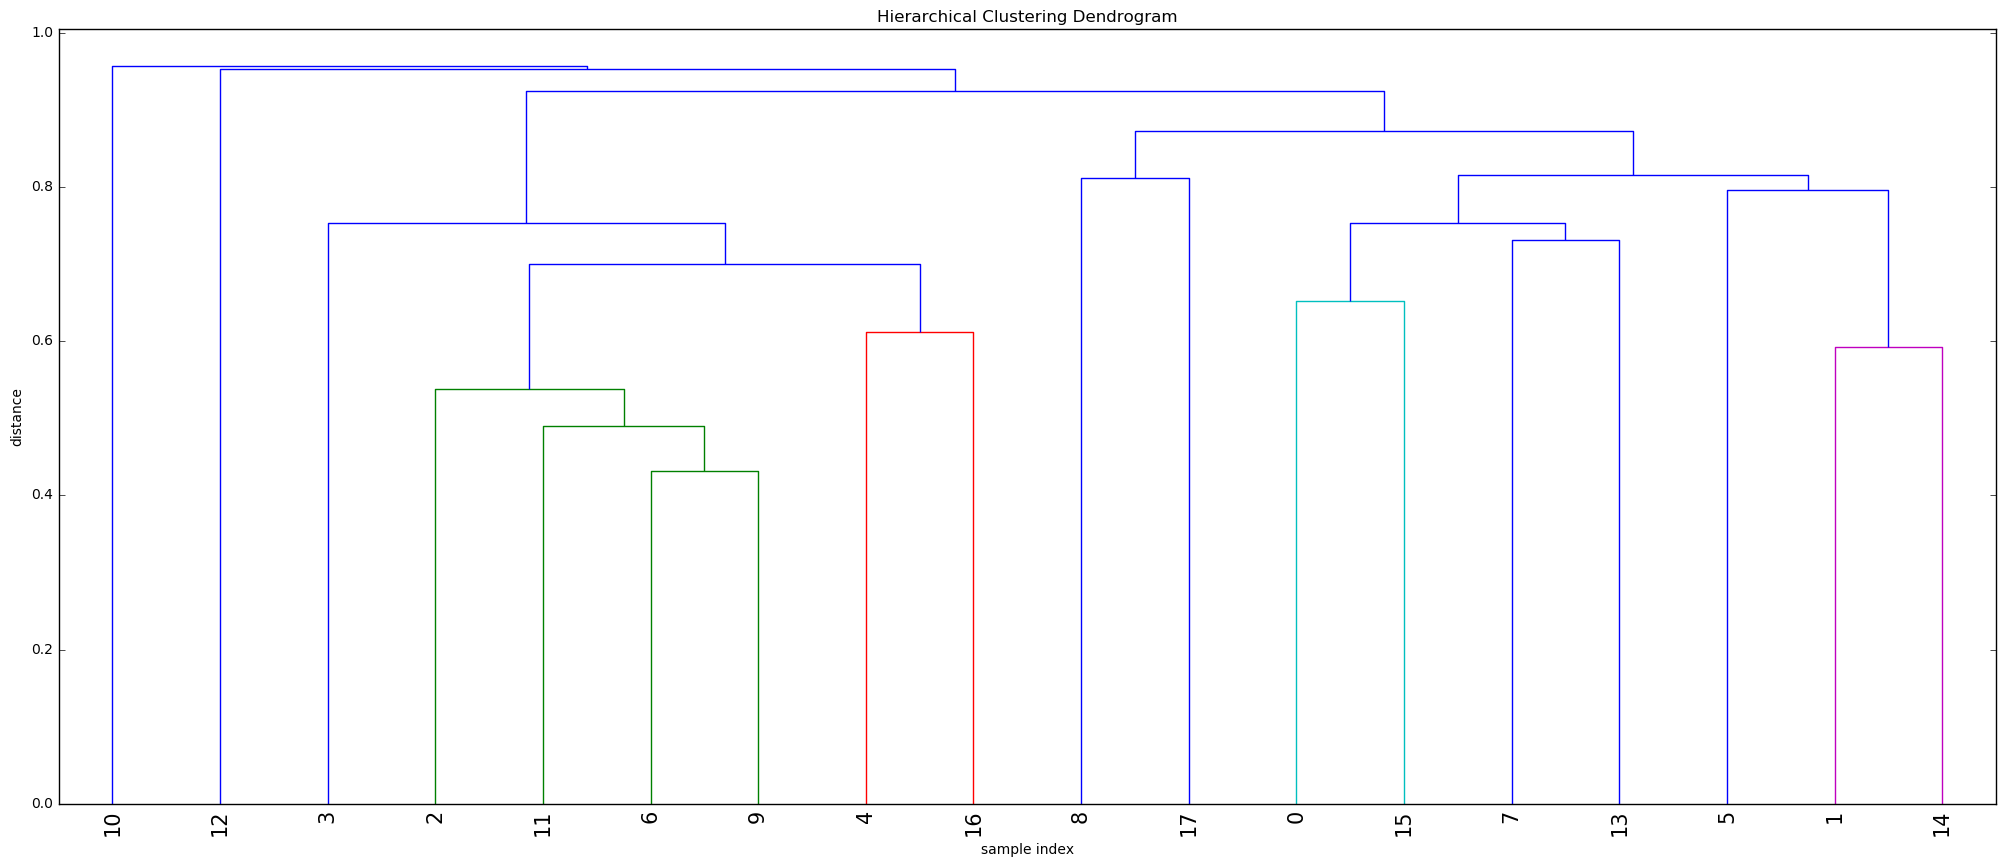

id| True | Pred | Sentence
 0 | 0    | 1    | small business and trade association would be able to band together , combine UNK employee to create insurance buying pool , then obtain health insurance from broker exempt from most state and local regulation .
 1 | 0    | 1    | million of americans go uninsured each year , and million more find the cost of stay insure all but prohibitive .
 2 | 1    | 1    | only this year , come back from the first major injury of UNK career and a try personal offseason , strahan be do more than tilt at windmill .
 3 | 1    | 1    | UNK be 12th on the all - time sack list and still hold the record for most sack in a season .
 4 | 1    | 1    | UNK say UNK believe UNK be always fend off competition for UNK role as the focus of the giants ' defense .
 5 | 0    | 1    | the small business health fairness act , author by rep. sam johnson , r - texas , have little potential to expand insurance coverage and great potential to sabotage the exist health care ma

In [25]:
demo_evaluation(scdv)

### Picking out some examples

Class-based clustering evaluation:
Precision = 0.8666666666666667 | Recall = 0.8666666666666667 | F1 = 0.8666666666666667




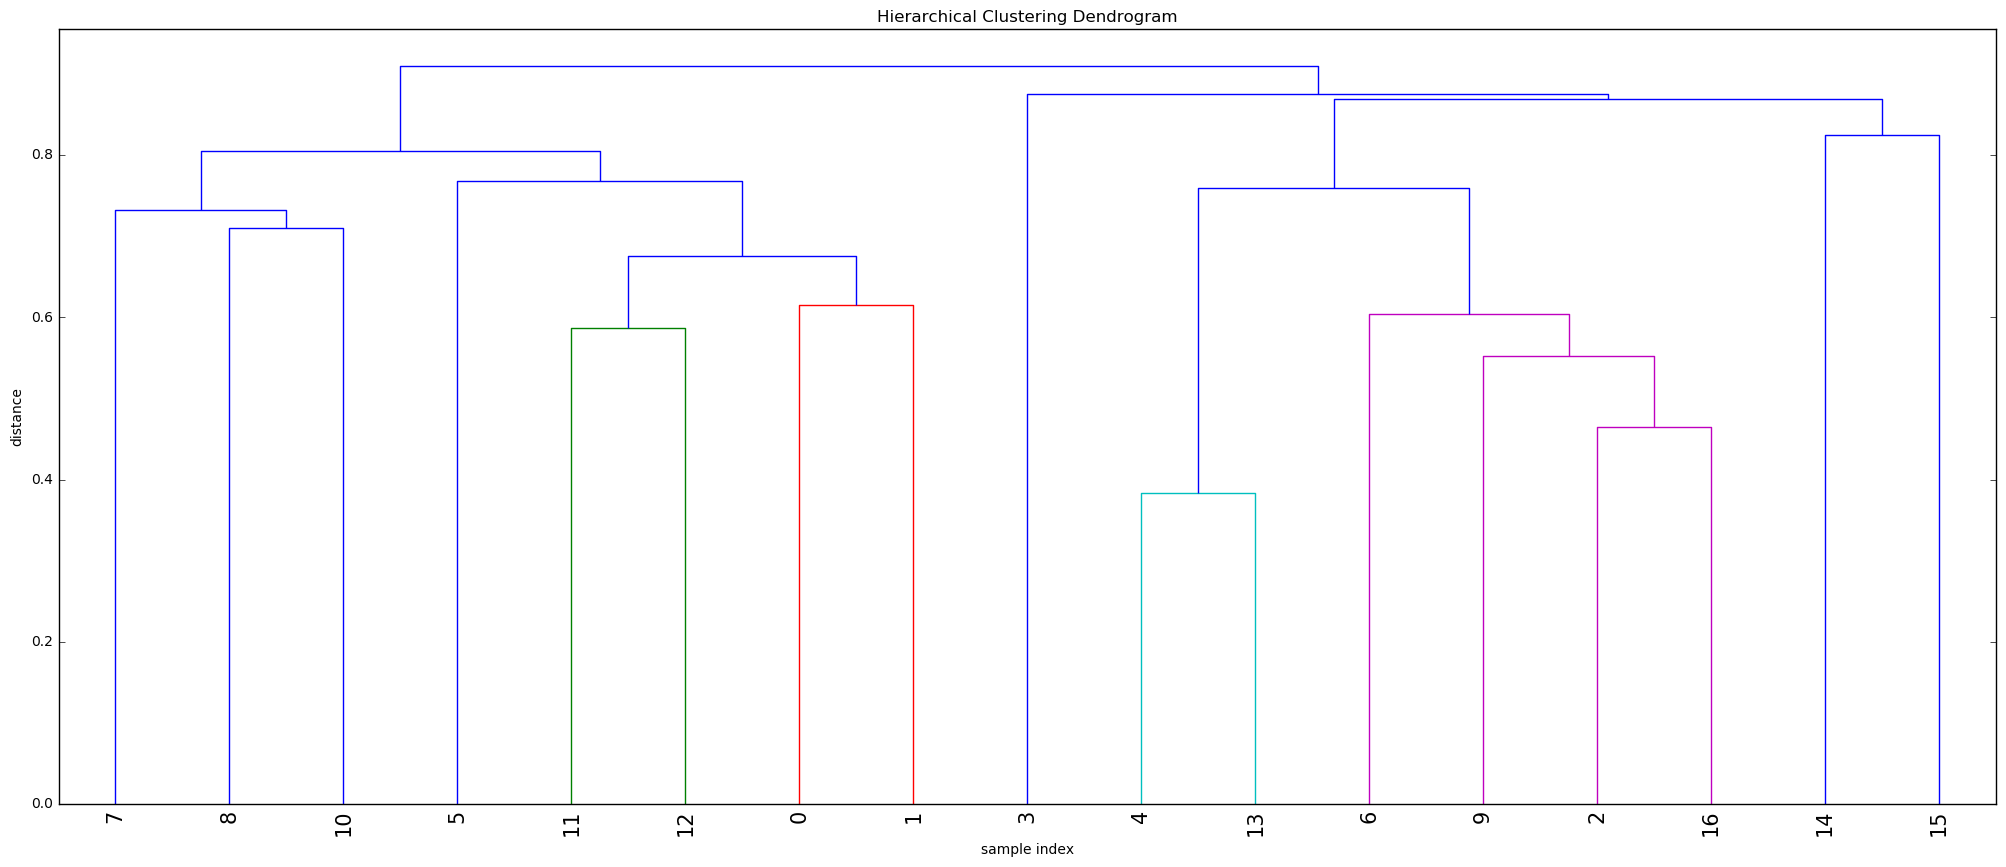

id| True | Pred | Sentence
 0 | 1    | 1    | `` UNK like the wildness in UNK , UNK like the love in UNK , UNK like the hate in UNK -- UNK just all make sense to UNK , '' say pitt , who first read jim harrison 's novella about three brother in love with the same woman when UNK be in college .
 1 | 1    | 1    | `` UNK be the only character that UNK ' ve have that UNK feel there be no one good to play , in all seriousness . ''
 2 | 0    | 2    | the slowdown for housing will not be severe , UNK say .
 3 | 0    | 2    | UNK say apartment construction will be fairly strong in 1995 .
 4 | 0    | 2    | an oversupply of unsold house already appear to be develop , UNK say .
 5 | 0    | 1    | `` play UNK close to the vest .
 6 | 0    | 2    | UNK say rise mortgage interest rate would because housing start to decline 8 percent in 1995 and remain lackluster until the middle of 1996 .
 7 | 1    | 1    | the role have earn a golden globe nomination as good actor for pitt , who first burst on the

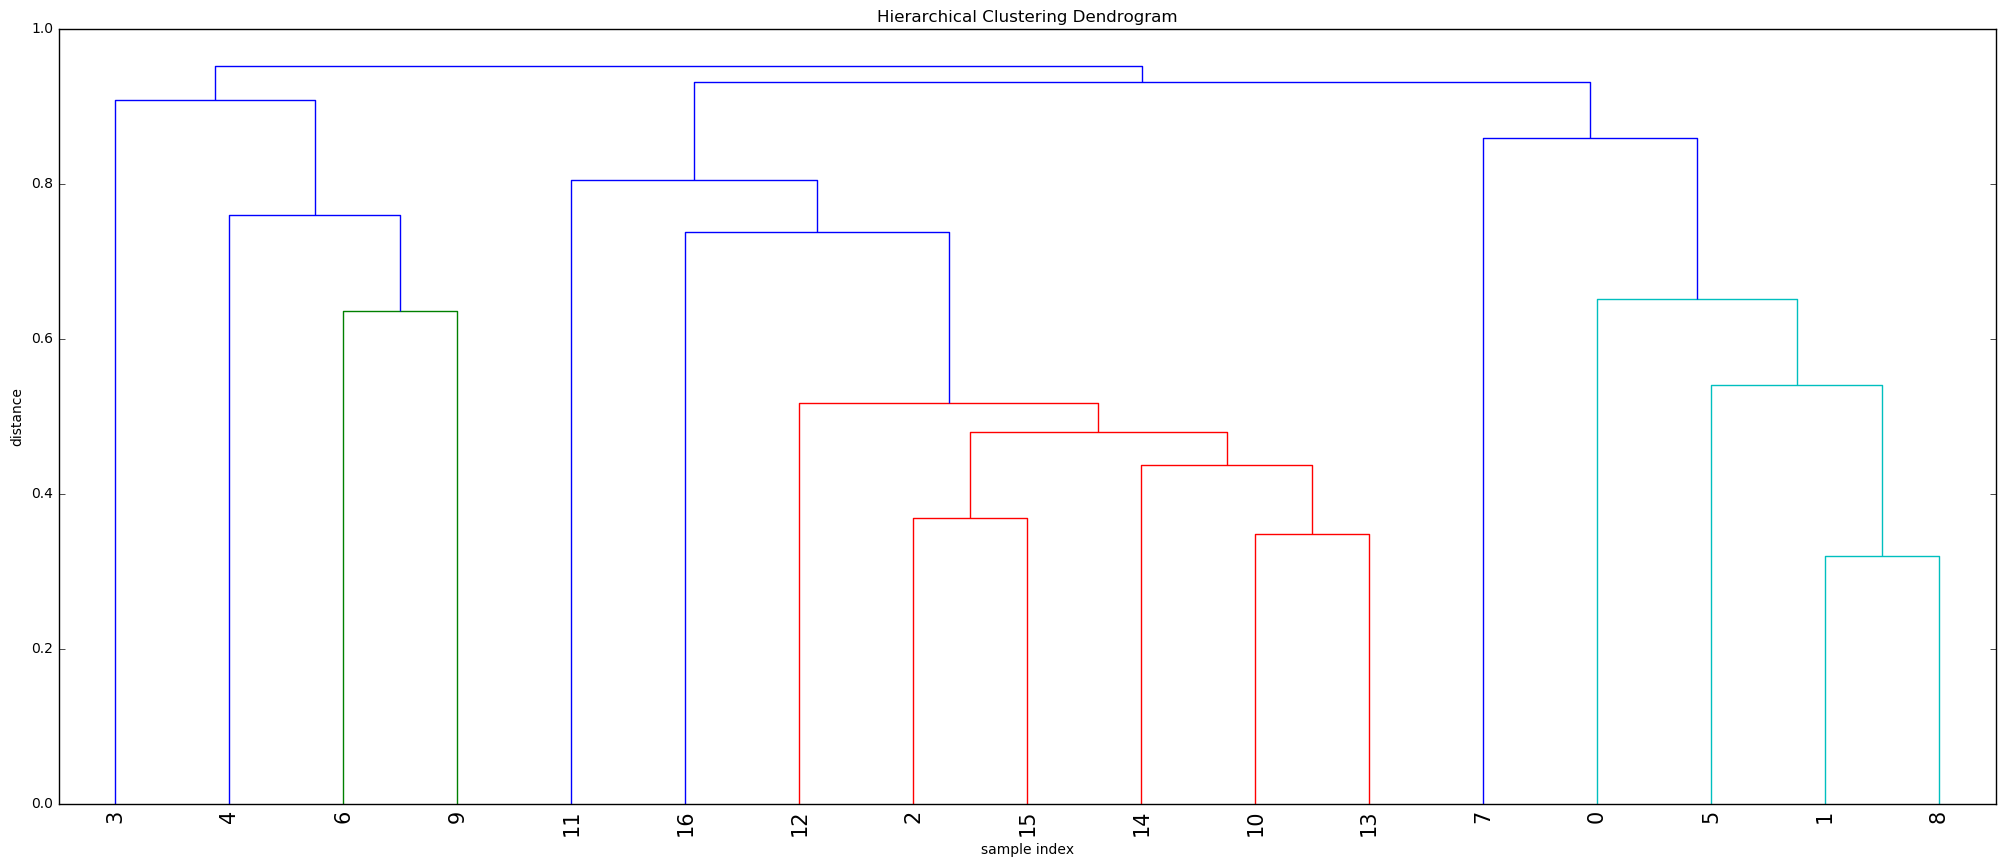

id| True | Pred | Sentence
 0 | 0    | 2    | UNK be an odd but somehow fitting end to a political campaign that in several way have just enough to win : just enough money .
 1 | 0    | 2    | just enough vote .
 2 | 1    | 2    | the debt daewoo fail to pay be part of 170 billion won ( $ 150 million ) that come due this week , UNK main creditor , the korea development bank , say .
 3 | 0    | 1    | kit bond by 0.6 percent .
 4 | 0    | 1    | UNK be the close election for governor since 1976 , when democrat joseph p. UNK edge then - gov .
 5 | 0    | 2    | just enough political contact .
 6 | 0    | 1    | just hour after bob holden learn wednesday that UNK have be elect governor of missouri , phone service to UNK campaign headquarters be cut off .
 7 | 1    | 2    | `` but the submission of an agreement to restructure by the labor union do n't necessarily mean the company will escape final bankruptcy . ''
 8 | 0    | 2    | just enough time .
 9 | 0    | 1    | holden , the two - t

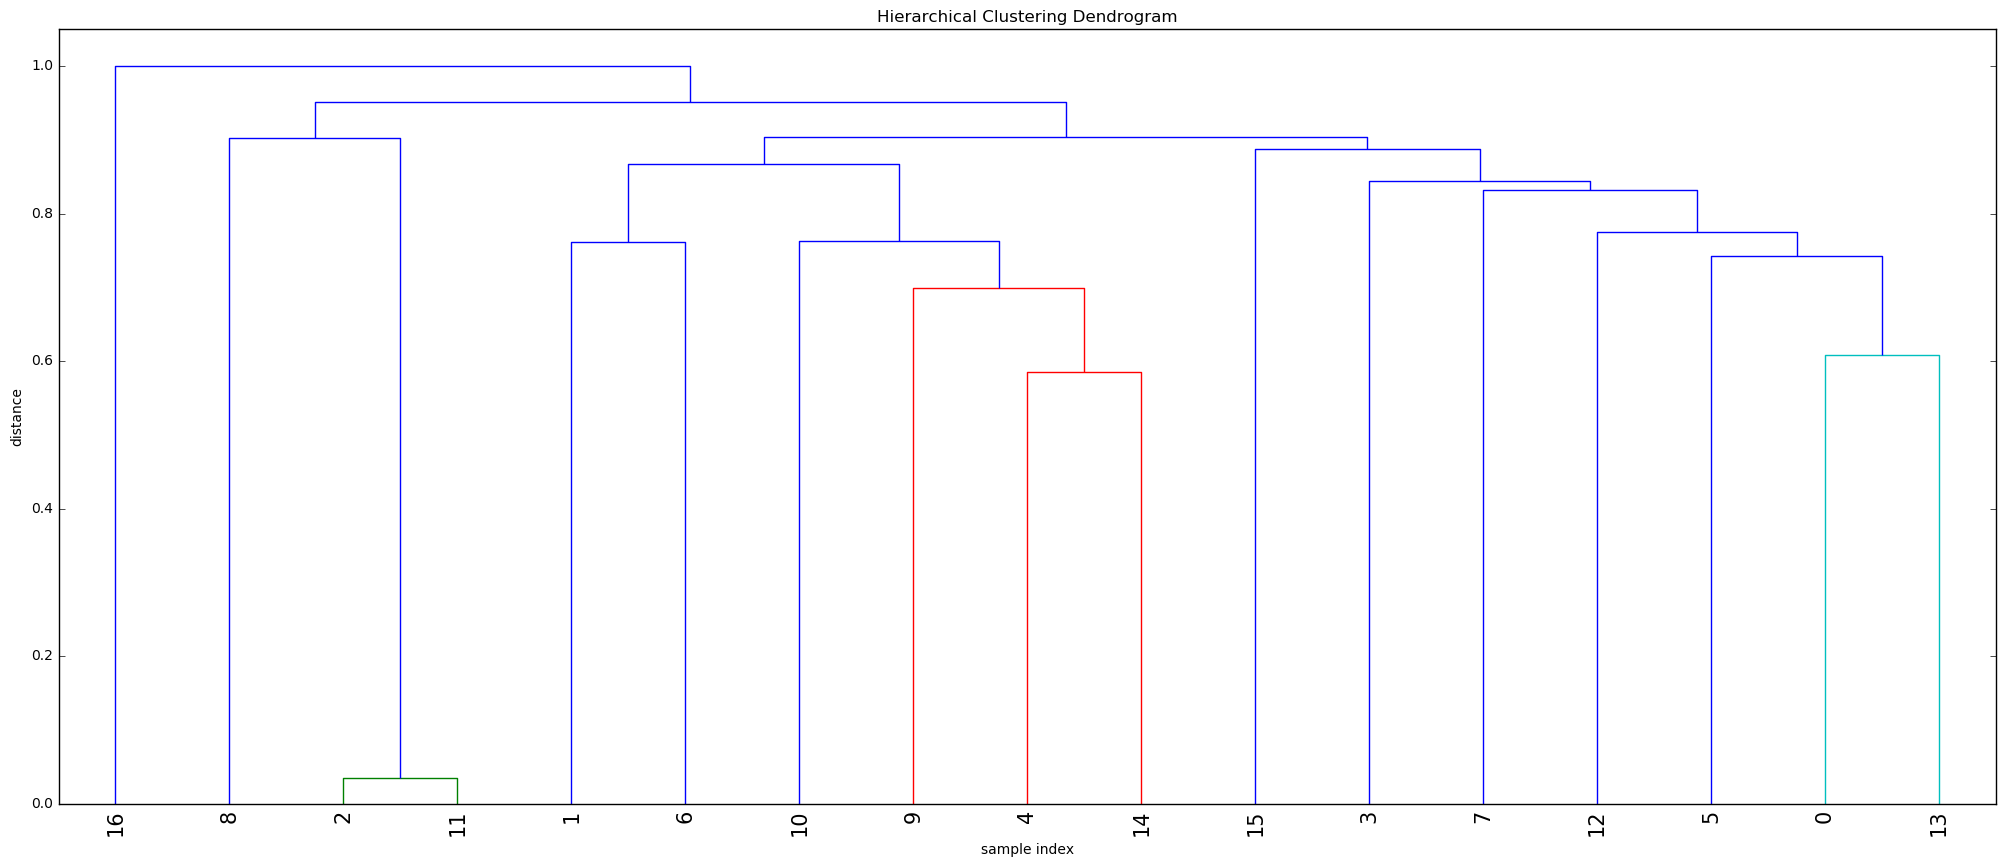

id| True | Pred | Sentence
 0 | 0    | 1    | latin america could once have be describe as the land of the UNK and the home of the coup .
 1 | 0    | 1    | there be also a sense that level of official corruption be intolerably high .
 2 | 1    | 1    | 2 .
 3 | 1    | 1    | the heart of a woman , by maya angelou .
 4 | 0    | 1    | what be more , in the late 1980 and early 1990 , incumbent political party in latin america be defeat at least once in nearly every country that hold free and fair election .
 5 | 0    | 1    | in the mid-1990 , the electorate have reward the good performance of various politician with reelection , particularly noteworthy in the case of argentina , brazil and chile .
 6 | 0    | 1    | many still believe that economic success be ephemeral and that democracy 's bad enemy be the politician who claim to speak in UNK name .
 7 | 1    | 1    | volume 4 of the poet 's autobiography take UNK to new york
 8 | 1    | 1    | undaunted courage , by stephen e. ambros

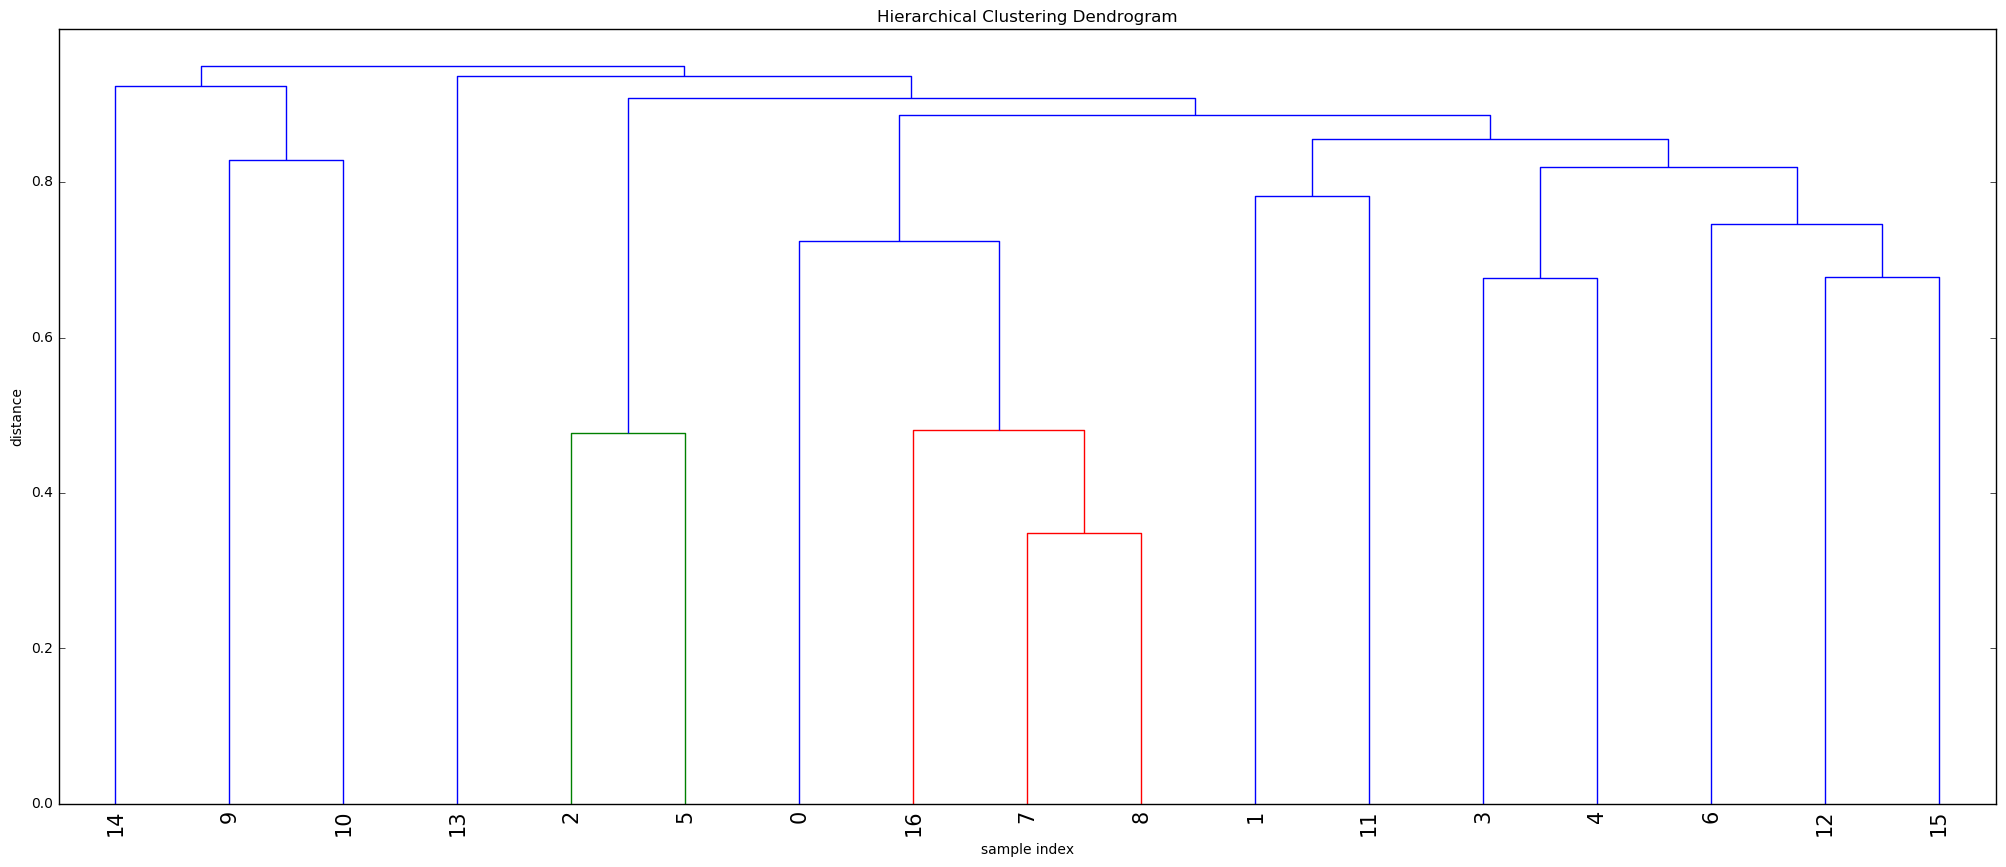

id| True | Pred | Sentence
 0 | 1    | 2    | not only stevens and dingell find UNK treat like old bull put out to pasture .
 1 | 0    | 2    | `` even in good time , the trucking community work on razor - thin , single - digit margin , '' say david gerard , who run a chicago - area business that be the large truck dealership in the united states .
 2 | 0    | 2    | nocera - column ( undated ) -- the credit crisis be ripple up and down the economy in way that may not create obvious headline but that affect the way people do UNK business and live UNK life .
 3 | 0    | 2    | but at chrysler , the day before thanksgiving be the moment of reckon for endanger member of UNK white - collar work UNK .
 4 | 0    | 2    | for the last month , many of the conversation at chrysler 's headquarters campus begin with a simple but emotionally charge question : `` be UNK stay or go ? ''
 5 | 0    | 2    | talk business column by joe nocera .
 6 | 1    | 2    | as UNK watch the procession , lawmaker 

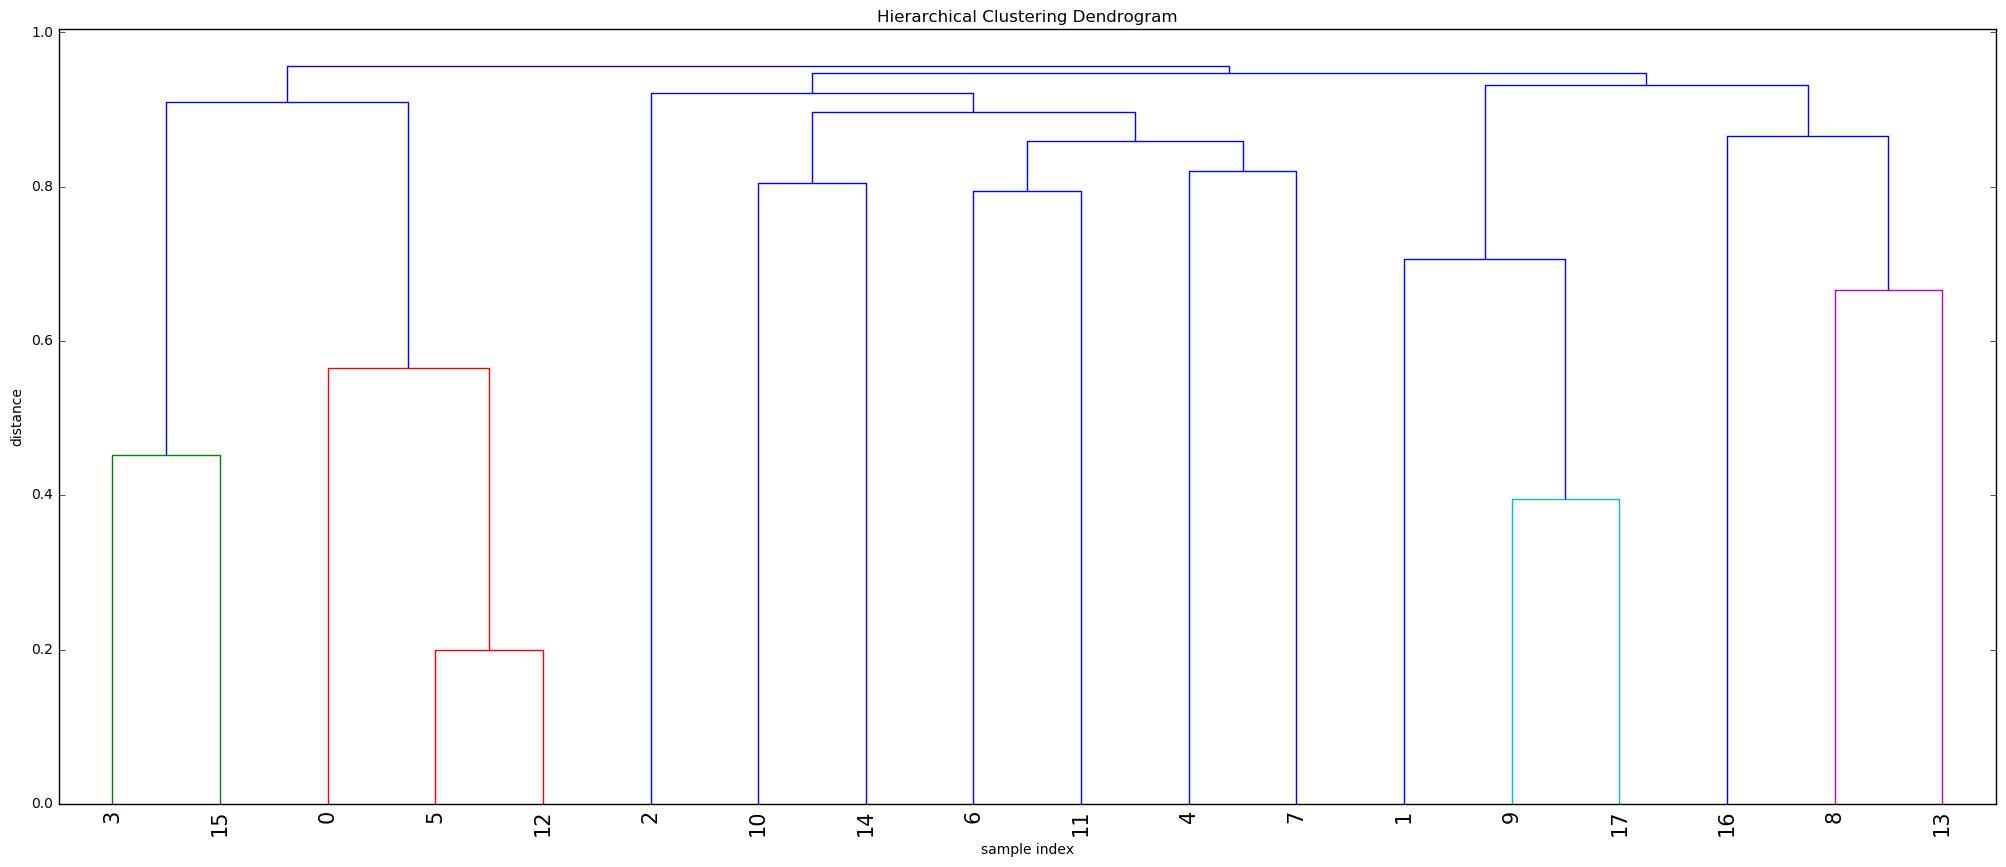

id| True | Pred | Sentence
 0 | 0    | 1    | penn state lose to michigan .
 1 | 1    | 2    | but UNK also flash advertisement to user and spit out coupon .
 2 | 1    | 2    | the poles , hungarians and czechs be way ahead of UNK , thank to a leawood , UNK , company .
 3 | 0    | 1    | so long , vols .
 4 | 0    | 2    | just when UNK think the bowl championship series ranking be hopeless , thing clear up .
 5 | 0    | 1    | tennessee lose to arkansas .
 6 | 1    | 2    | american , believe UNK or not , be behind the curve when UNK come to use automate teller machine .
 7 | 0    | 2    | sure , there be no playoff system , but consider the significance of saturday 's game .
 8 | 1    | 2    | `` UNK think UNK will start to see the same thing here , '' say michael brown , chief executive officer and chairman of euronet .
 9 | 1    | 2    | user in poland and hungary can buy voucher for mobile phone minute .
 10 | 0    | 2    | the lion ' roar be completely silence .
 11 | 1    | 2   

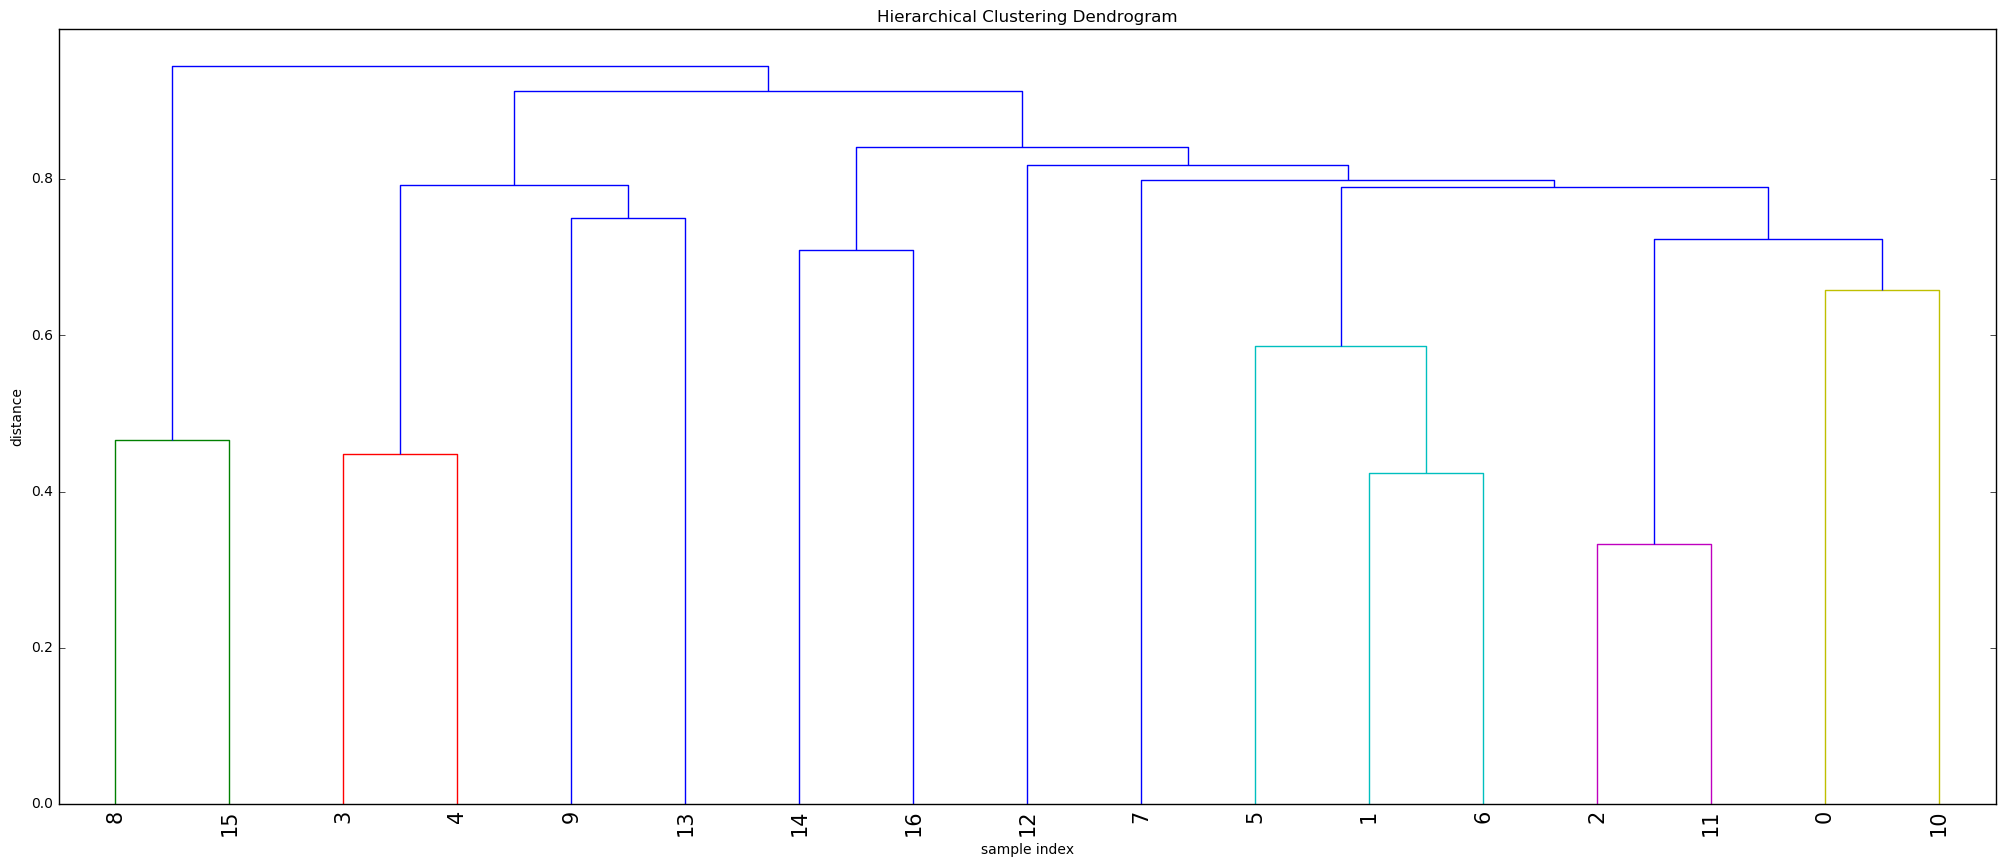

id| True | Pred | Sentence
 0 | 0    | 2    | the court say the first amendment give regulator more leeway to restrict advertising that child be likely to encounter than to block ad aim at adult .
 1 | 0    | 2    | anheuser - busch cos . and an advertising firm today ask the u.s. supreme court to review a baltimore ban on tobacco and alcoholic beverage billboard in residential neighborhood .
 2 | 0    | 2    | a federal appeal court uphold the restriction in november , say UNK do n't violate the first amendment of the u.s. constitution because UNK be design to protect child .
 3 | 1    | 2    | japanese stock trade little changed as plan to split up nippon telegraph and telephone corp. lift phone stock and concern about wan government spending weigh on construction stock .
 4 | 1    | 2    | japan 's cabinet approve a bill to break up nippon telegraph and telephone corp. into small unit and send the legislation to the parliament today .
 5 | 0    | 2    | anheuser - busch and penn adv

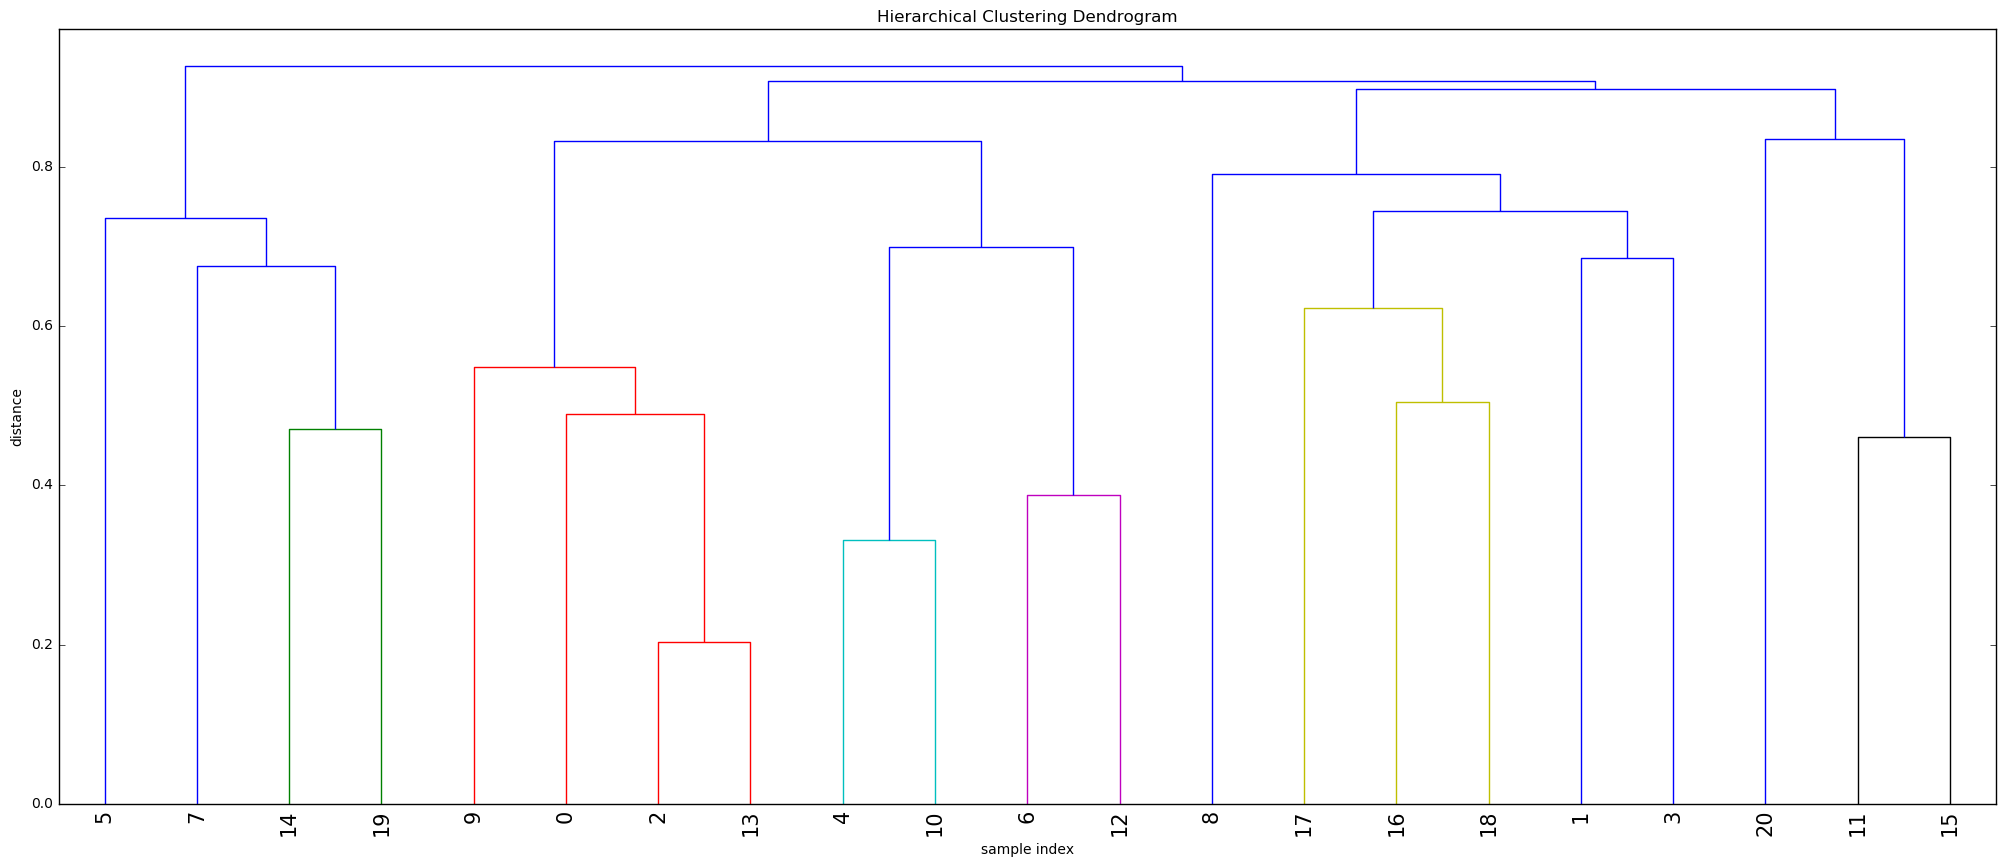

id| True | Pred | Sentence
 0 | 1    | 2    | murphy , equipment manager ken UNK , assistant keith robinson and trainer don del negro routinely order takeout , and murphy pick UNK up .
 1 | 0    | 2    | with confirmation hearing for foster not expect to begin until at least mid - march , the exchange reflect the mount strain between champion and critic of a nomination the white house have once regard as safe .
 2 | 1    | 2    | murphy try a third time .
 3 | 0    | 2    | the battle over the choice of dr. henry w. foster jr. as surgeon general take a divisive new turn sunday as senate majority leader bob dole say president clinton should withdraw the nomination if UNK become evident that UNK can not win UNK confirmation .
 4 | 1    | 2    | so iafrate give UNK atm card to murphy , tell UNK to stop by the bank and draw some money out for UNK , then pick up lunch .
 5 | 1    | 1    | by then , a line of customer be form behind UNK .
 6 | 1    | 2    | murphy , dress in a bruin warmup s

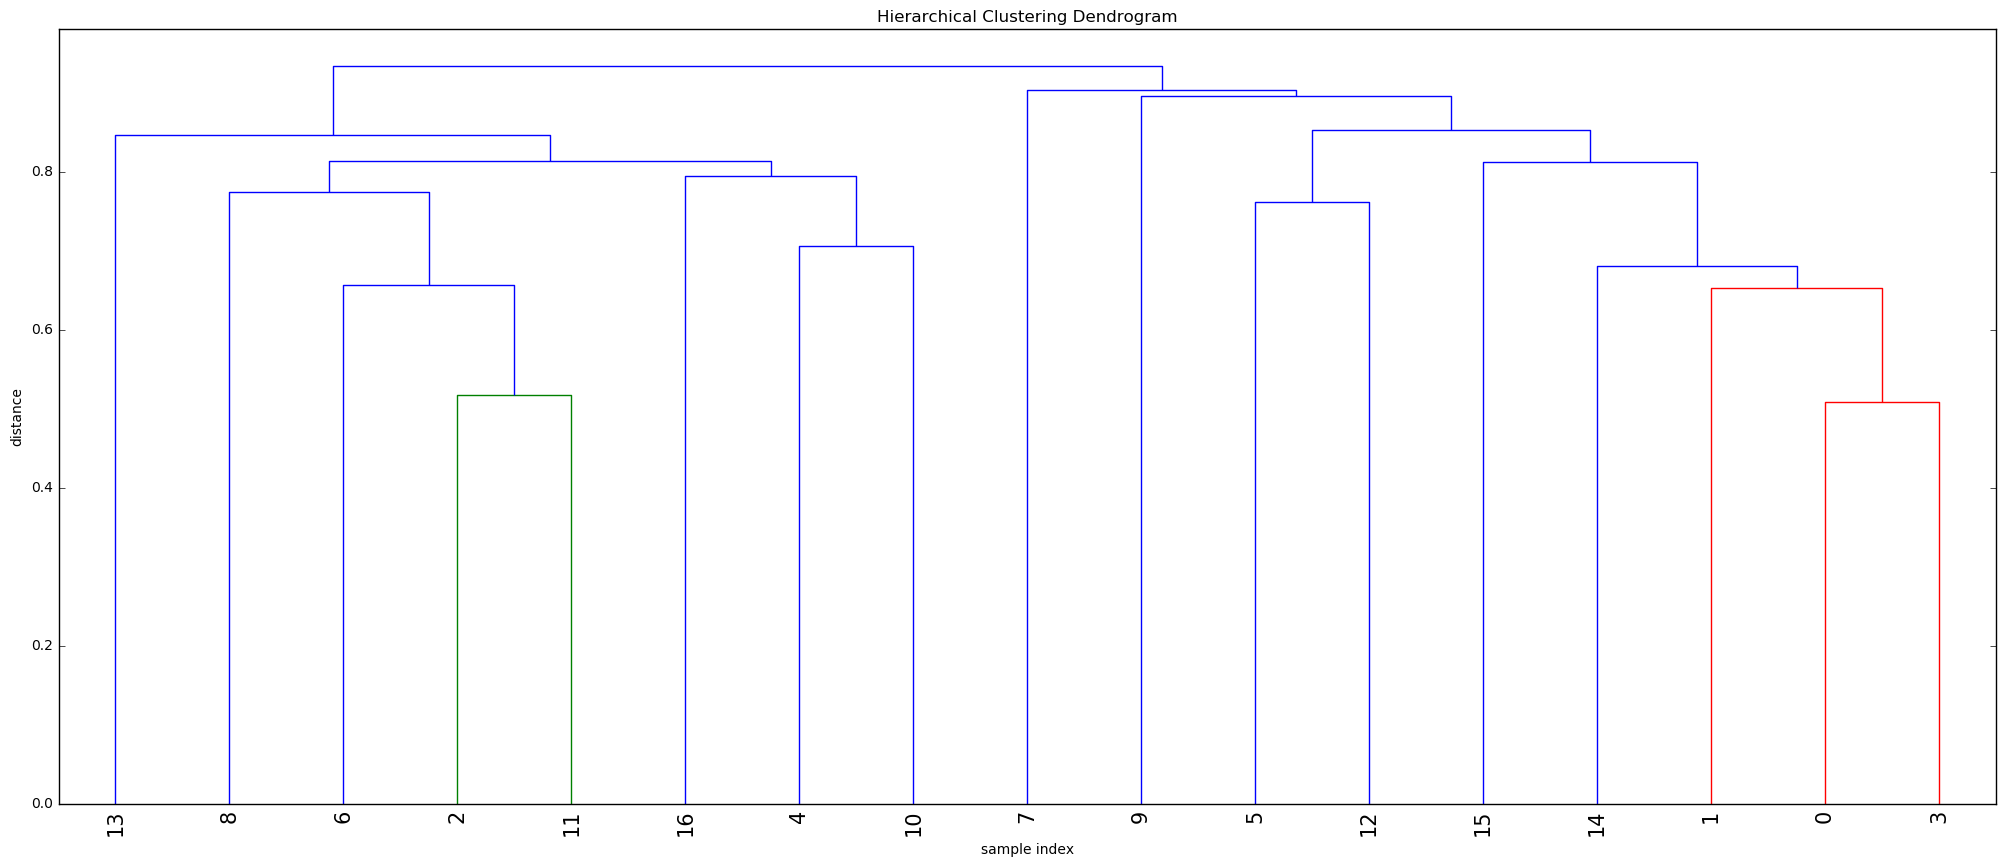

id| True | Pred | Sentence
 0 | 1    | 2    | sotheby 's have be talk to several developer about the coliseum site at columbus circle , which the state and the city be sell .
 1 | 1    | 2    | house hunting be never easy in manhattan , as sotheby 's and christie 's well know .
 2 | 0    | 1    | bear stearns cos . say earning in UNK fiscal first quarter rise 16 percent , lead by investment banking and trading .
 3 | 1    | 2    | when developer submit UNK proposal on UNK 1 , sotheby 's may be include in the plan of several developer .
 4 | 0    | 1    | that fall short of analyst ' average forecast of 84 cent a share , accord to ibes international inc. .
 5 | 1    | 2    | first there be the former alexander 's department store at lexington avenue and 58th street .
 6 | 0    | 1    | bear stearns do n't give a precise figure for return on equity .
 7 | 1    | 2    | for several year each auction house have consider relocate , but UNK requirement _ both ample space and a central locati

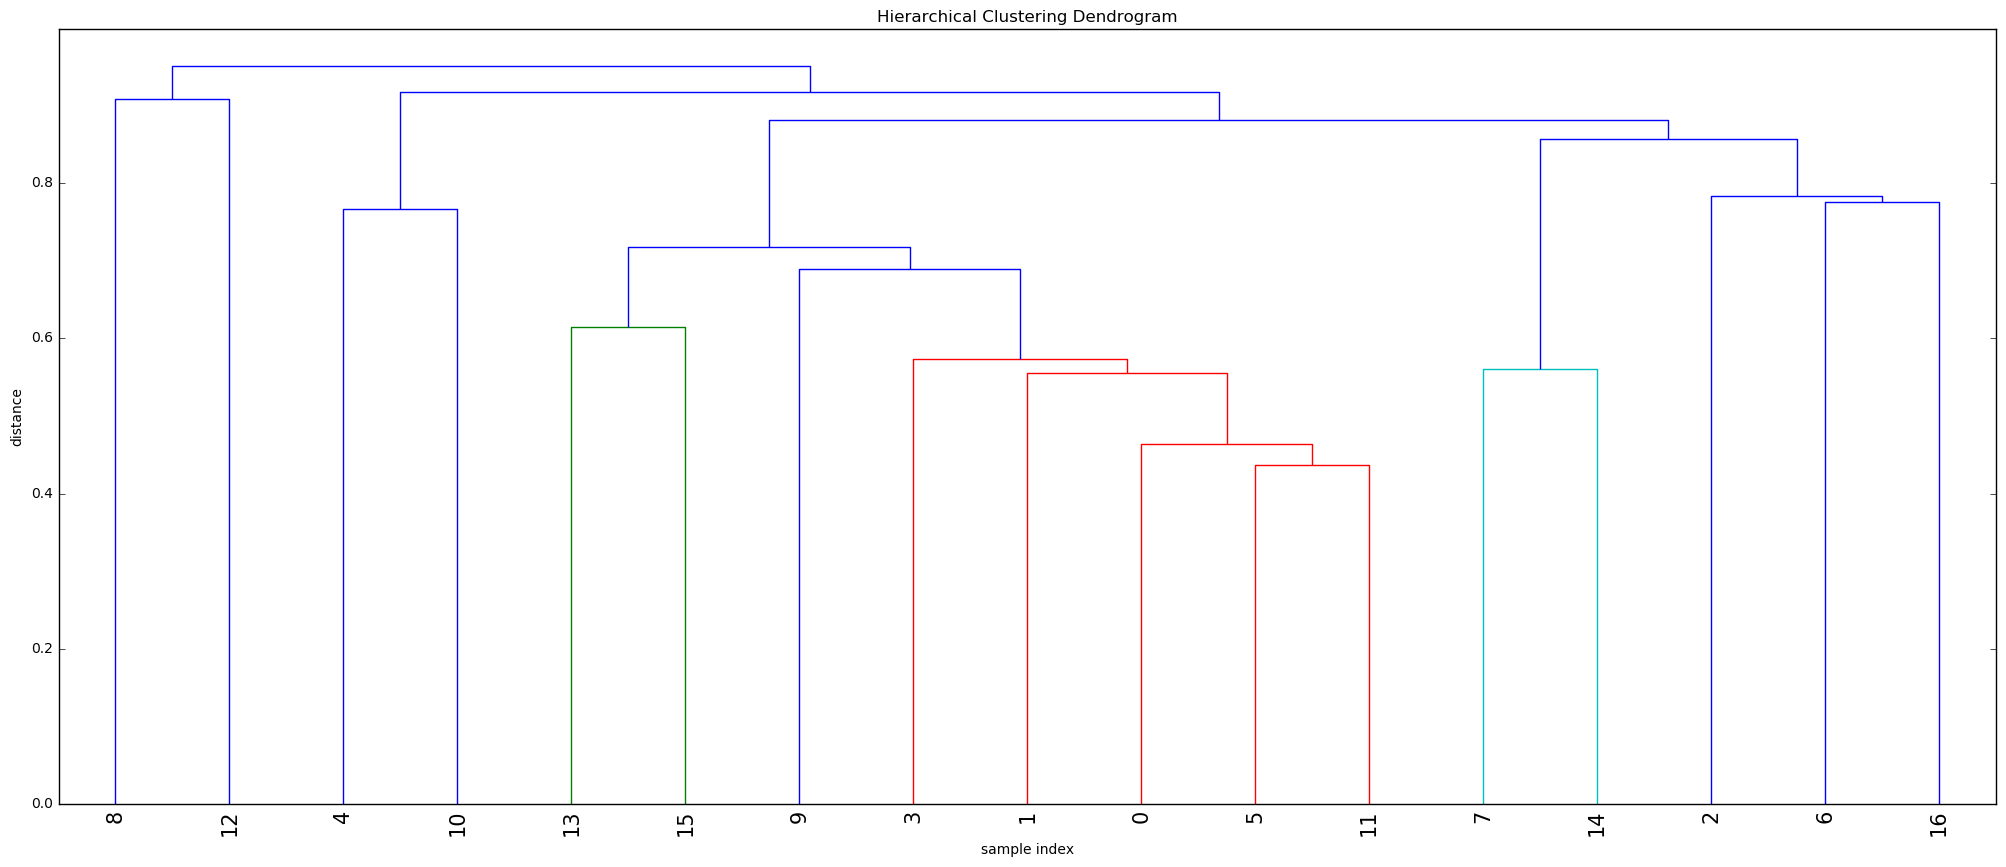

id| True | Pred | Sentence
 0 | 0    | 2    | and by that standard , ms. messinger 's visit signal the vast ethnic and electoral change that have sweep new york city over the last decade and that will likely shape the democratic primary and the general - election race in the year ahead .
 1 | 0    | 2    | `` over the course of UNK lifetime , UNK have change overwhelmingly , '' ms. messinger say tuesday of the electorate UNK face as UNK prepare to run for mayor , in between recount UNK trip in interview with hispanic and other news outlet in new york .
 2 | 1    | 2    | that could be attribute to the lack of a professional football team here as much as the fact most of the city 's rowdy be sleep off a saturday night of hyperactivity .
 3 | 0    | 2    | but ms. messinger 's choice of destination certainly be .
 4 | 1    | 2    | there be the stuff UNK see on tv _ james brown coordinate a mess of live stadium remote , tap interview and word of wisdom fling around by tv 's fearsome thre

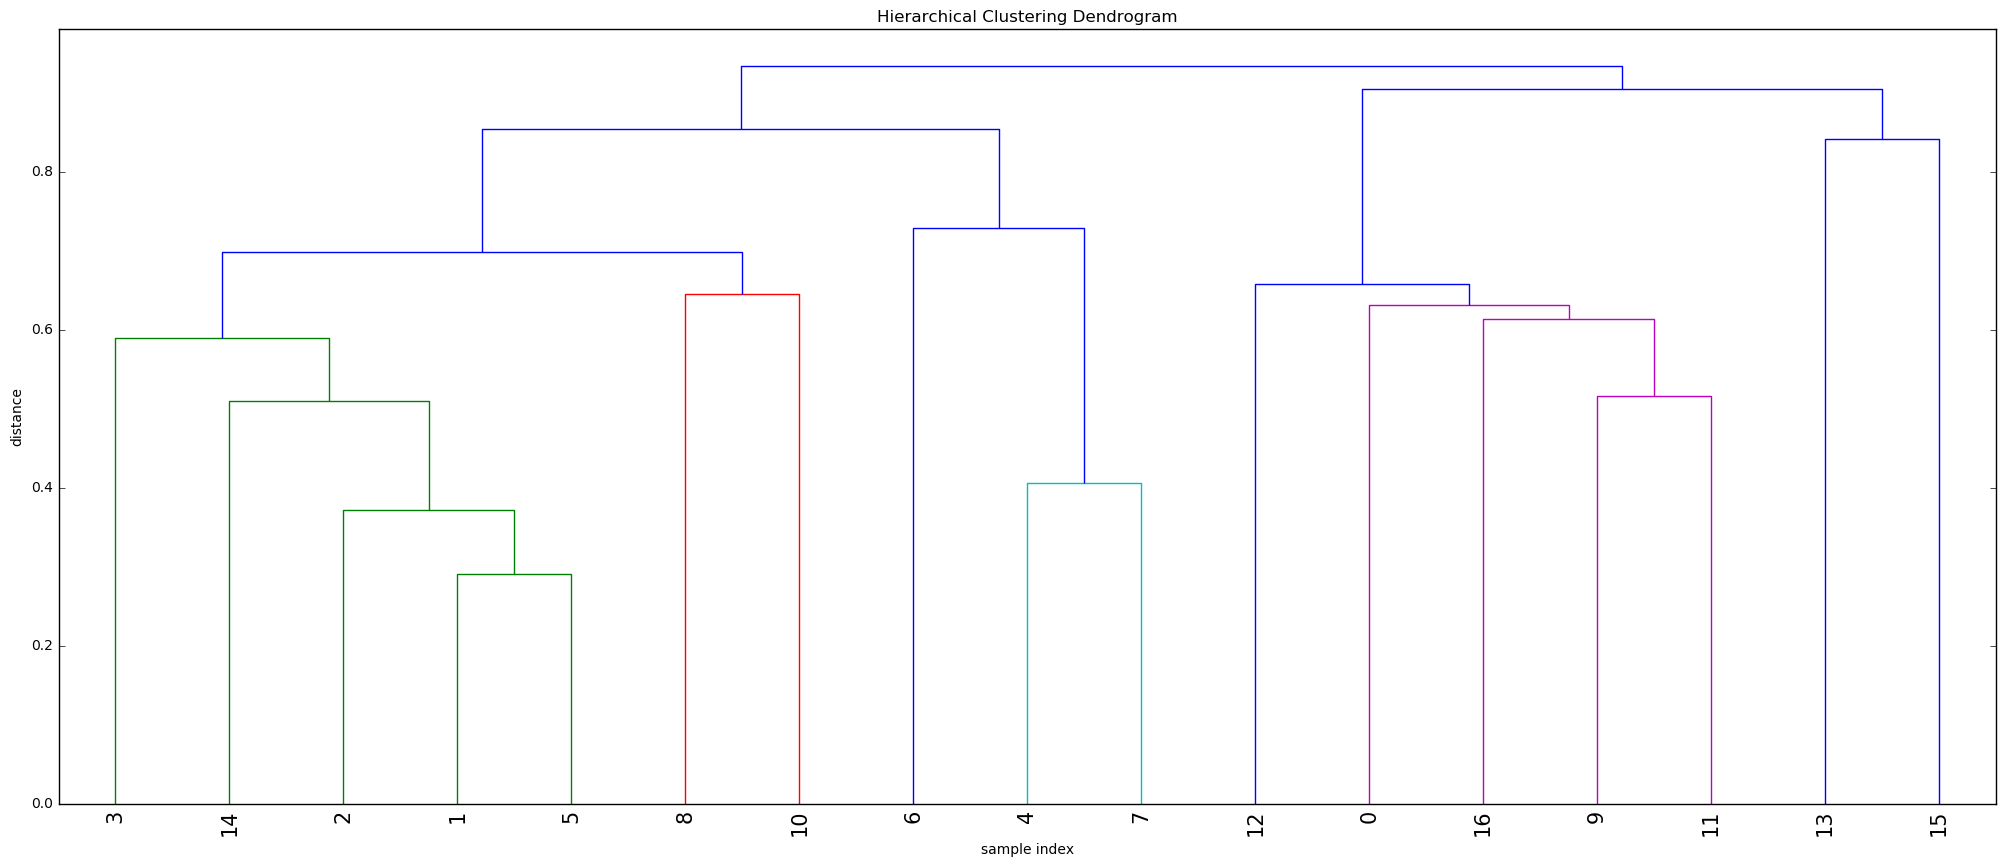

id| True | Pred | Sentence
 0 | 1    | 2    | opponent say that al gay , an entrepreneur who own the handful of business in the isolated outpost on arizona 85 , be just try to cash in on UNK corporate name , gringo pass inc. , and be be insensitive to anglo people and a war hero in the process .
 1 | 0    | 1    | bulgaria 's socialist prime minister zhan videnov on saturday tell a party congress UNK and UNK cabinet be resign after fail to push through emergency economic austerity measure , the sofia - base UNK bulgarian news agency report .
 2 | 0    | 1    | videnov say UNK expect bulgaria 's congress to approve UNK resignation before the end of december , accord to the british broadcasting service .
 3 | 0    | 1    | the international monetary fund have request a series of austerity measure before provide the government with low - cost loan bulgaria need to pay UNK creditor .
 4 | 0    | 1    | UNK have also head for five year the bulgarian socialist party , formerly the communist 

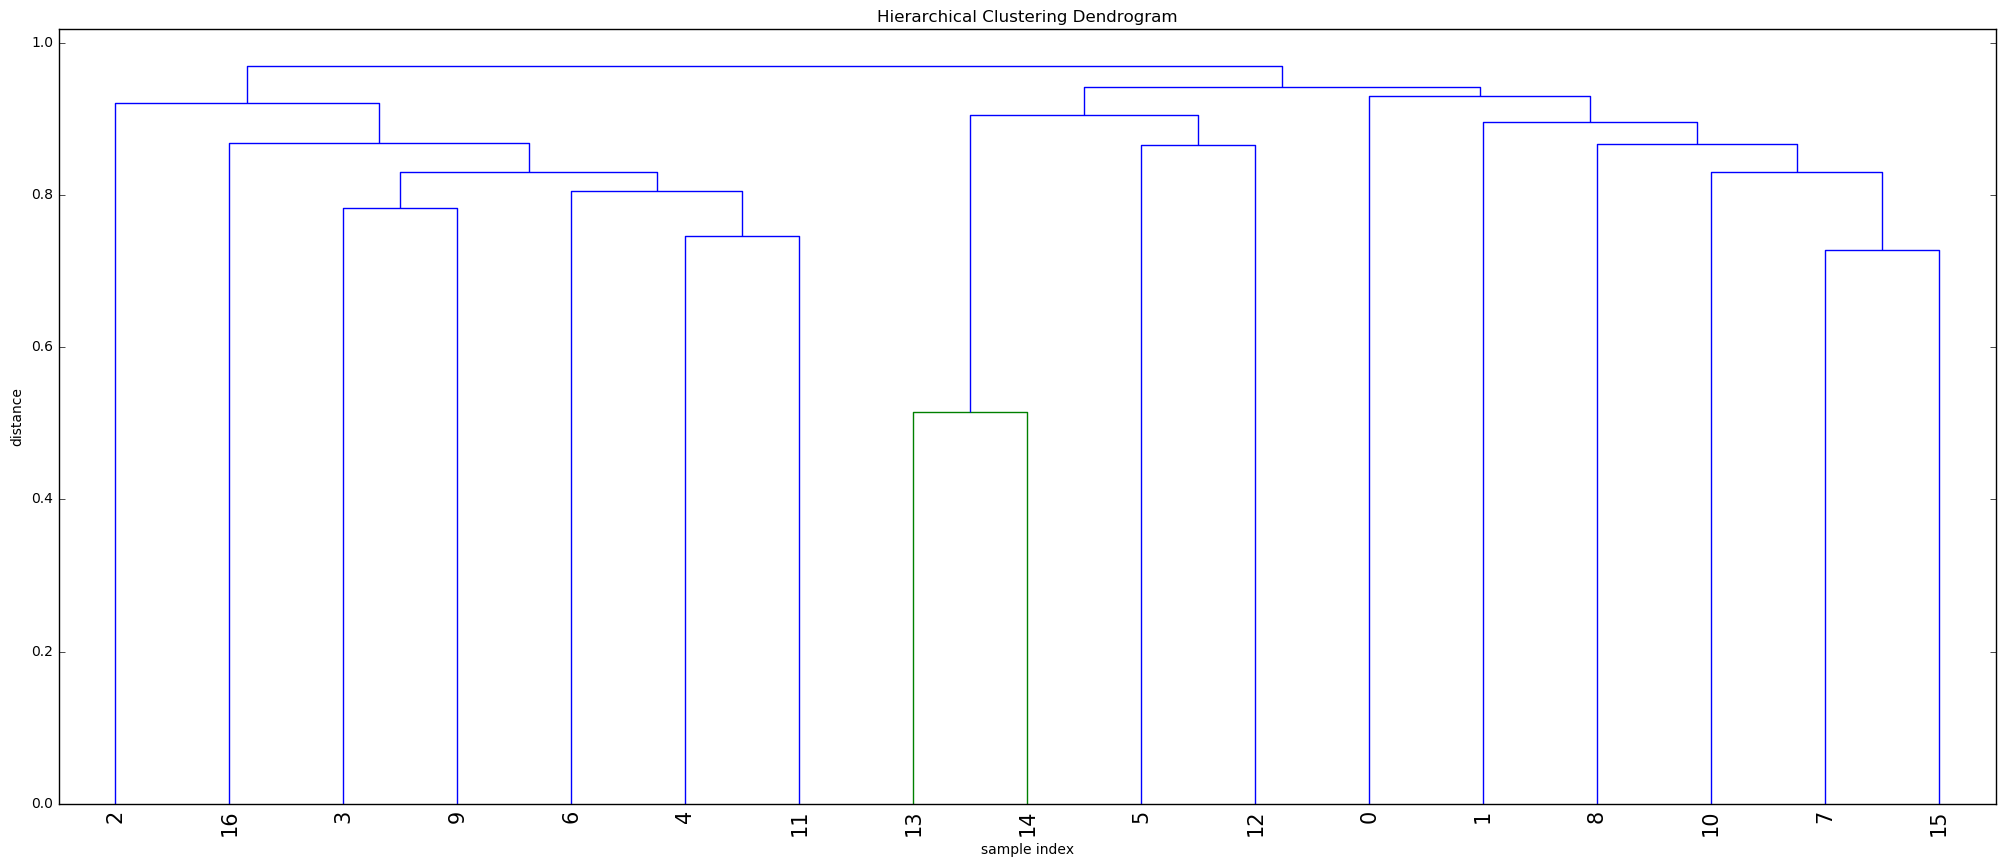

id| True | Pred | Sentence
 0 | 0    | 2    | depth do n't matter .
 1 | 1    | 2    | one that would lead UNK to a new and unwelcome phase of UNK life .
 2 | 0    | 1    | a good friend need to be as reliable as UNK car and as trustworthy as UNK safe - deposit box .
 3 | 0    | 1    | remember the teen year , when self - worth be largely base on the number of birthday party invitation UNK get ?
 4 | 0    | 1    | UNK want someone UNK can talk with about sick parent , relationship issue , the economy .
 5 | 1    | 2    | UNK have be there UNK entire 78 year , grow up downtown between the five and dime and olympia theater .
 6 | 1    | 1    | about then , UNK emerge from what UNK call UNK `` usual state of distract mental musing '' and realize UNK have take a wrong turn
 7 | 0    | 2    | a desire to be like rule .
 8 | 1    | 2    | more unwanted change , UNK think .
 9 | 1    | 1    | then , like the retired english teacher UNK be , UNK say aloud a line from shakespeare : `` UNK sigh 

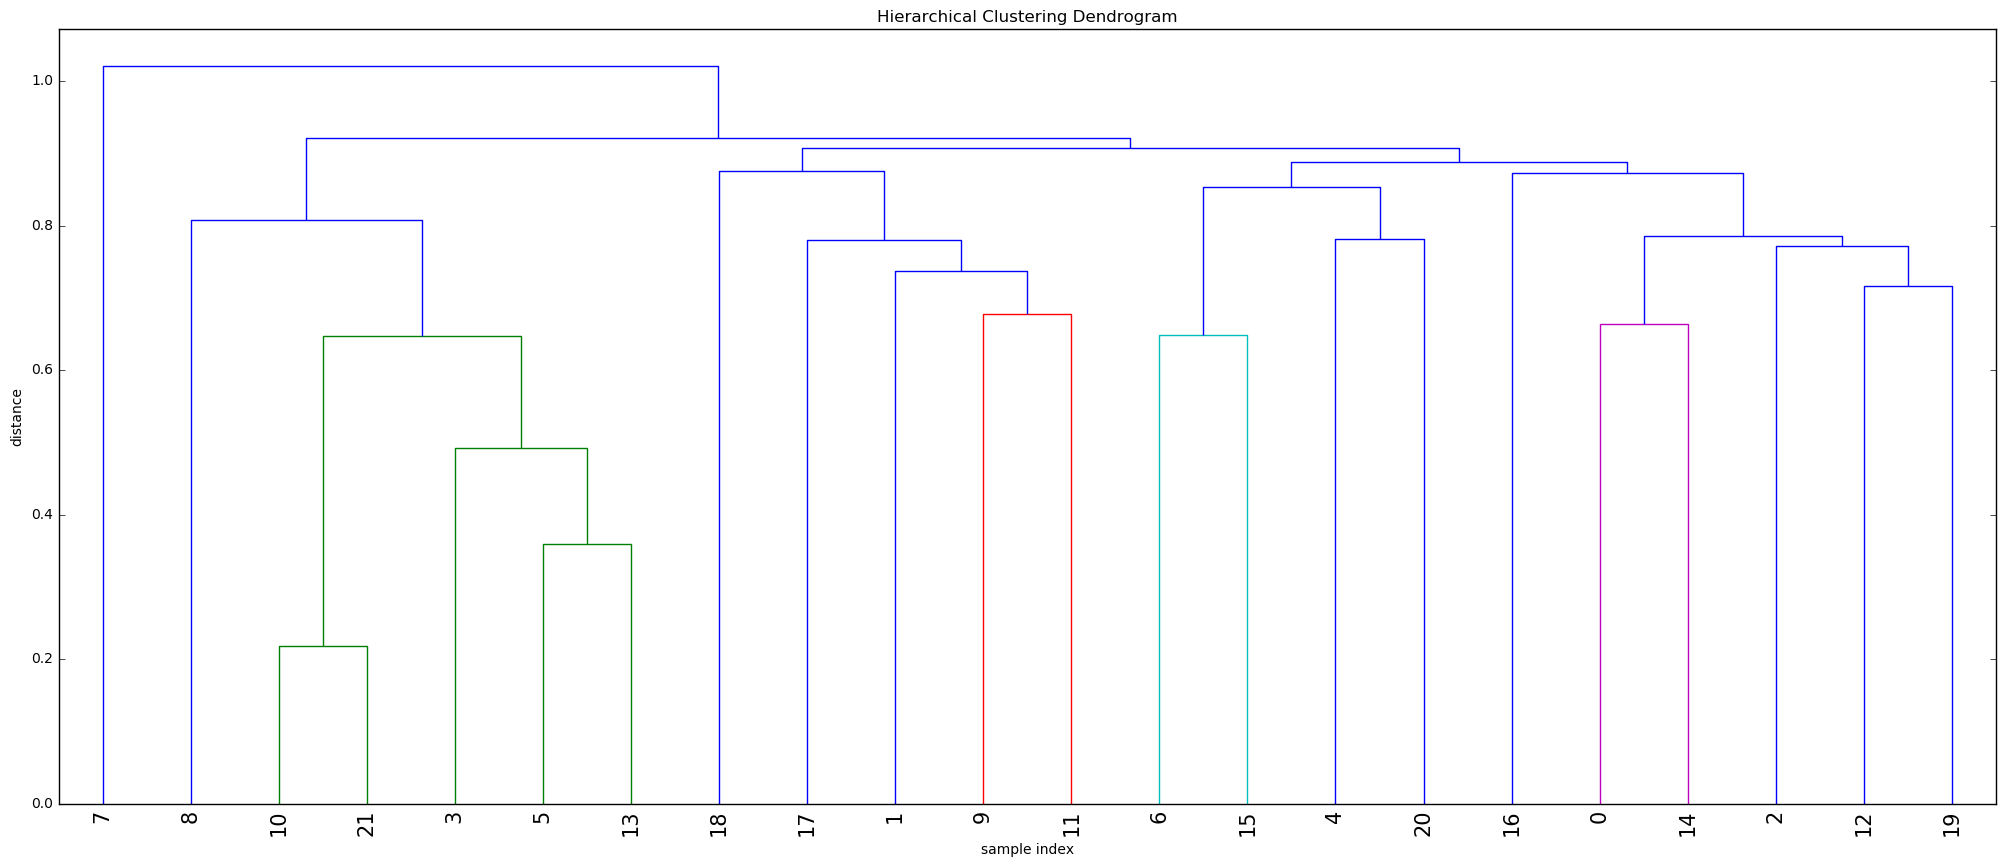

id| True | Pred | Sentence
 0 | 0    | 1    | now , the city the industry once eschew _ along with standard - issue , inside - the - beltway practice like lobby and write campaign check _ be full of visit high - technology baron and marquee lobbyist who be work long hour to press the industry 's agenda .
 1 | 0    | 1    | in a single day , UNK meet with more than 20 senator and house member , divide UNK attention carefully between the political party .
 2 | 0    | 1    | in september , meg whitman , the founder of the auction site ebay , make UNK third trip to washington this year .
 3 | 1    | 1    | green also play against former cowboys run back tony dorsett and UNK son , titans safety anthony dorsett , and dallas run back ron springs and UNK son , seattle cornerback shawn springs .
 4 | 0    | 1    | `` microsoft be a poster child for UNK industry , '' say connie correll , director of communication for the information technology industry council , a trade organization that represe

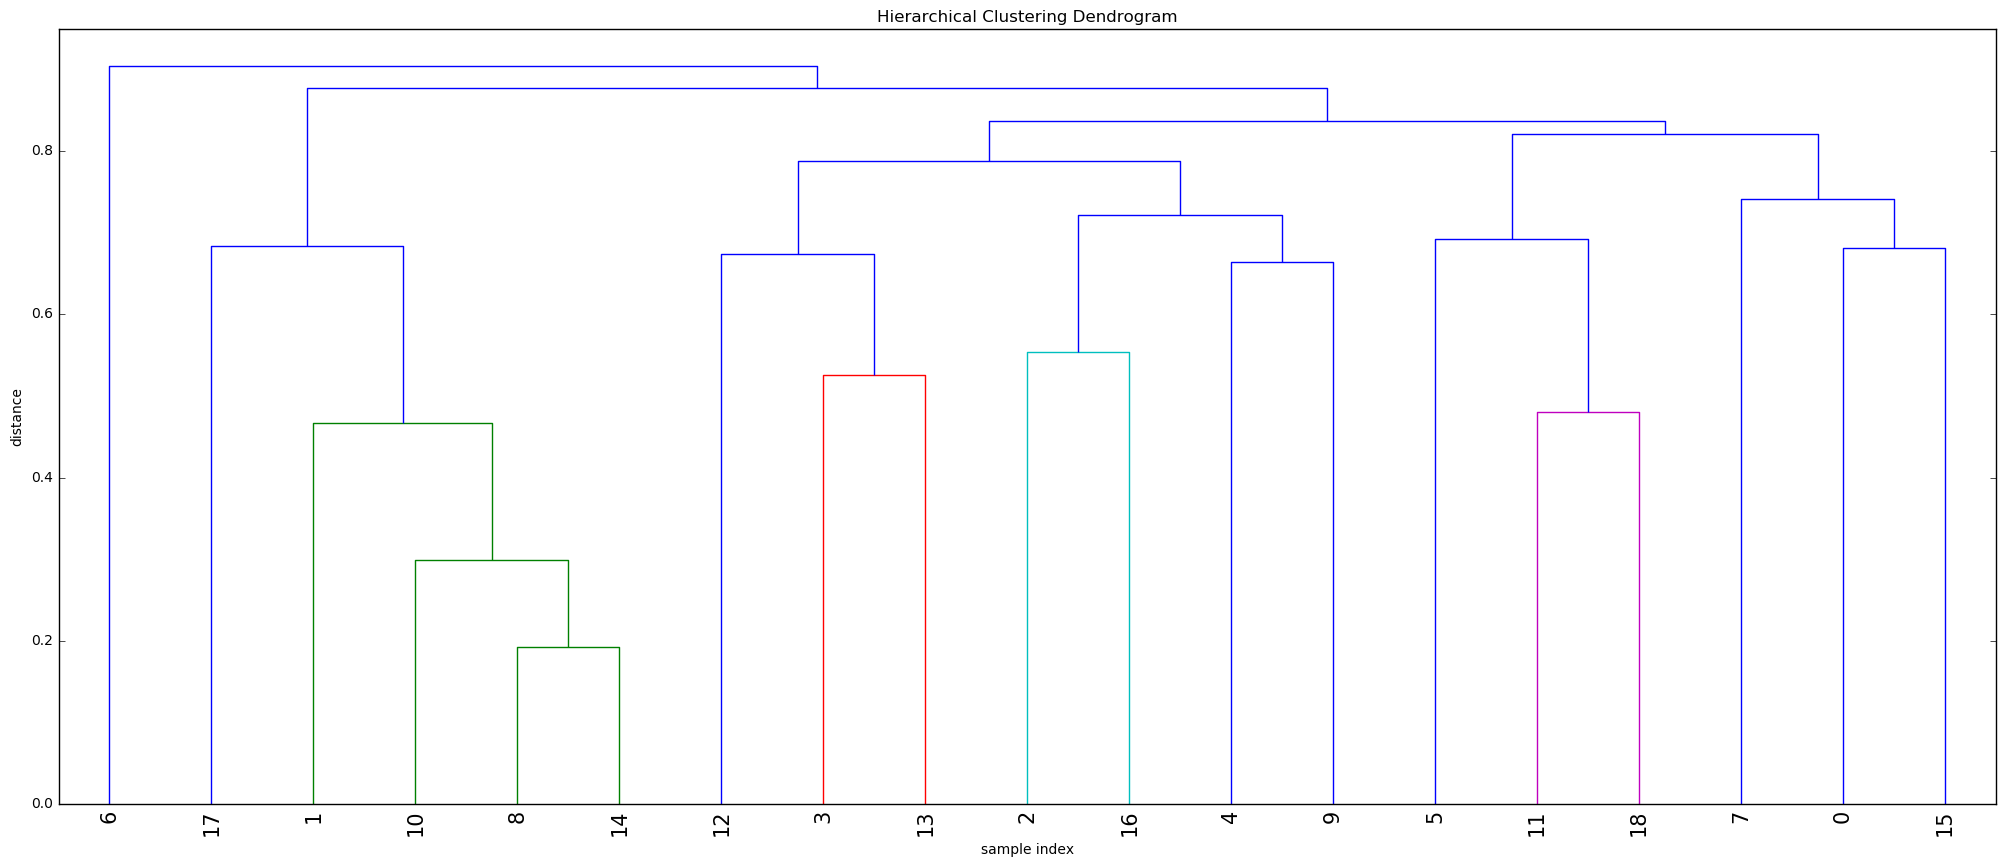

id| True | Pred | Sentence
 0 | 1    | 1    | the company say UNK financial condition have be deteriorate on the decline in real estate price and the increase in bad loan to real estate buyer .
 1 | 1    | 1    | nichiei finance co. , a nonbank financial service , say UNK file for bankruptcy in yokohama district court today .
 2 | 0    | 1    | the share of the new york - base owner of sheraton , caesars world casino , madison square garden and two sport team rise 1/2 to 42 UNK 5/8 in UNK trading of UNK , compare with the three month daily average of 1.04 million .
 3 | 0    | 1    | last year 's result be restate because itt be spin off from the original itt in december , while share outstanding fall 7 percent to 118.2 million .
 4 | 1    | 1    | the tokyo stock exchange suspend trading of the company 's share .
 5 | 0    | 1    | revenue rise 2.5 percent to $ 1.67 billion from pro forma revenue of $ 1.62 billion .
 6 | 0    | 2    | `` as previously announce , UNK gaming result come

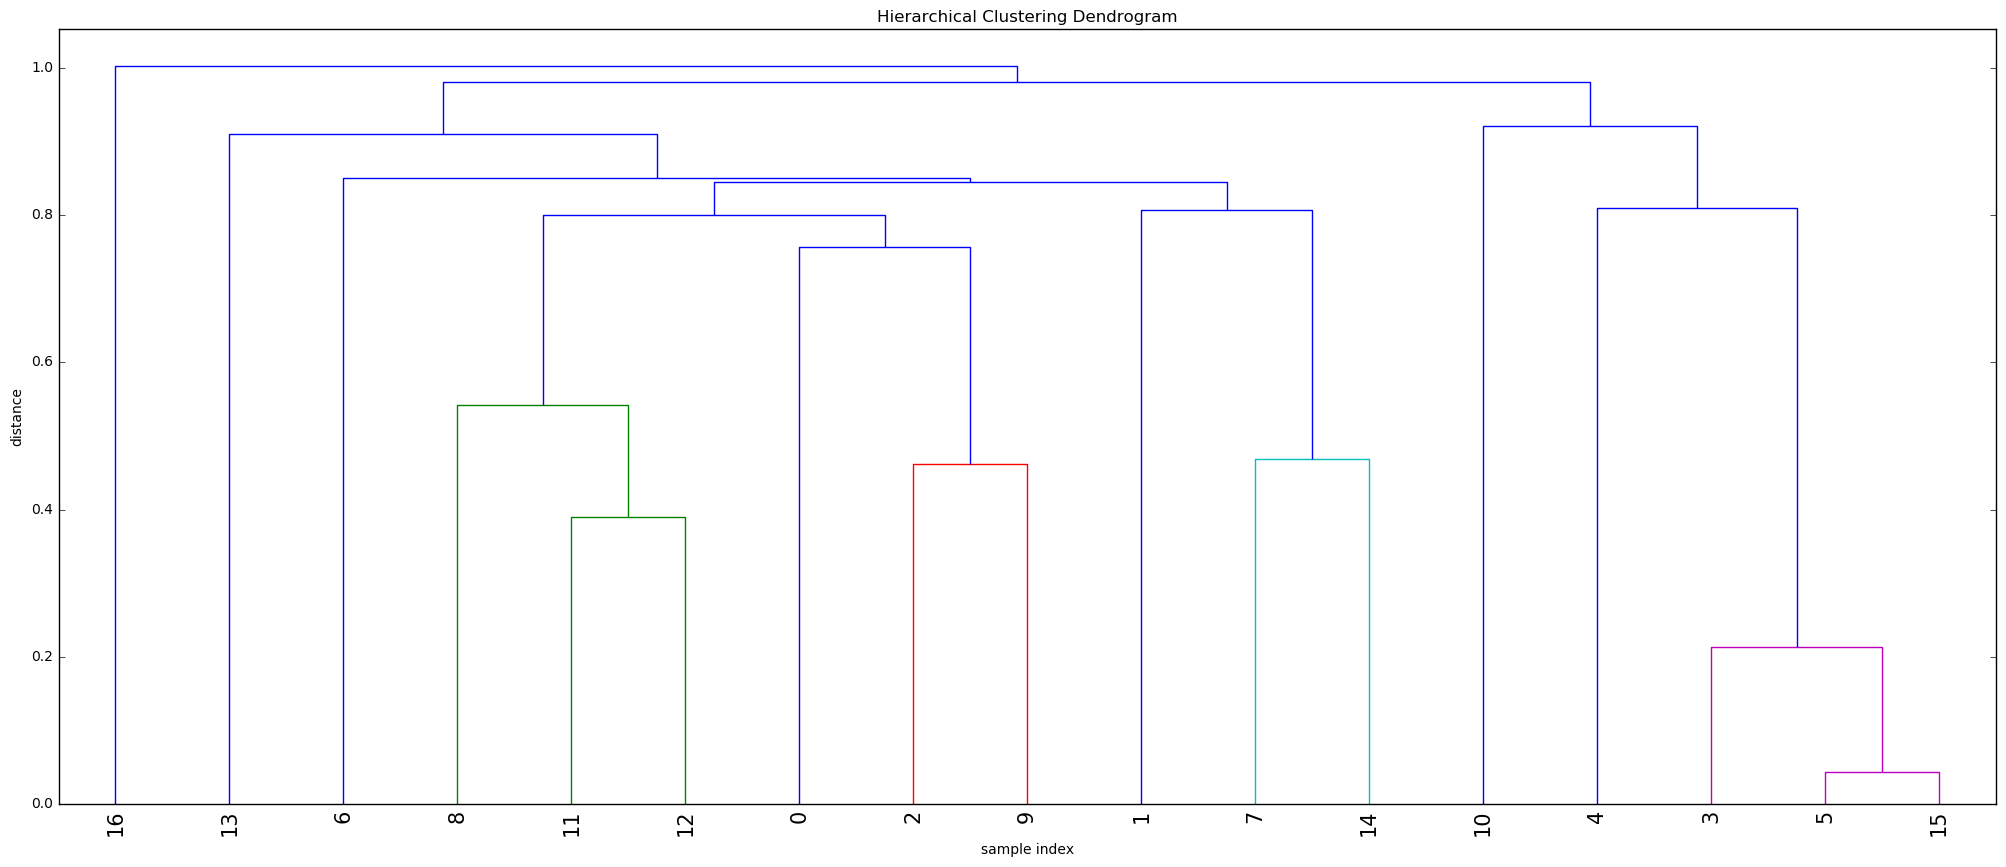

id| True | Pred | Sentence
 0 | 0    | 1    | the sun be barely up , and already the student be immerse in this never - never land of `` time between . ''
 1 | 0    | 1    | the high - pitch voice , intersperse with pierce , unrestrained laughter , propel the bus toward ballston spa middle school and high school .
 2 | 1    | 1    | one of those glimpse come at the end of the regular season , when denver win seven of UNK last eight game at the pepsi center .
 3 | 0    | 1    | `` do not touch UNK !
 4 | 1    | 1    | but what about play in UNK own arena ?
 5 | 0    | 1    | `` put UNK back ! ''
 6 | 0    | 1    | gina UNK yell at the boy , who ' ve decide to rearrange the magnetic number on the inner wall that mark each row .
 7 | 0    | 1    | along with UNK buddy , greg welch , a shaggy - head seventh - grader , and adam UNK , an eighth - grader with blond hair and brace , UNK command everyone 's attention , include the bus driver 's .
 8 | 1    | 1    | denver -- ask denver nuggets 

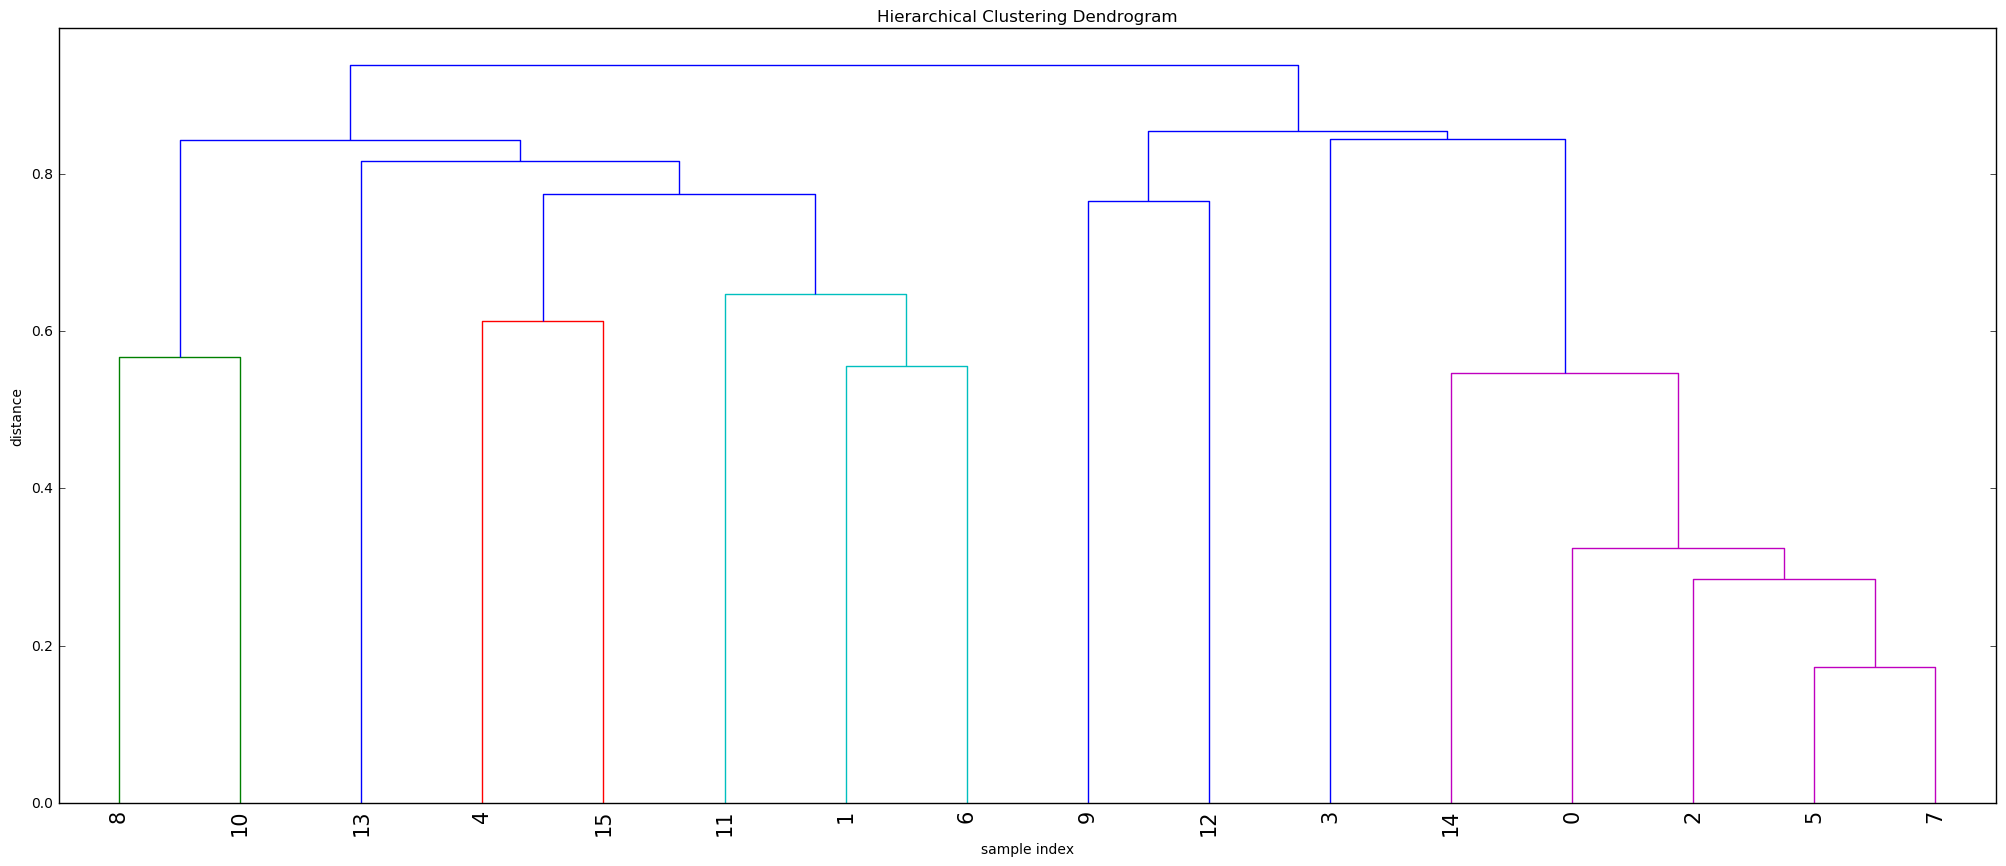

id| True | Pred | Sentence
 0 | 1    | 2    | ganadero , colombia 's large bank , rise 1.5 percent to 232 peso .
 1 | 0    | 1    | the battery be lead - acid , but instead of the flat plate use in conventional car battery , these have be wind into spiral that have far more surface area per unit volume .
 2 | 1    | 2    | the spanish company say ganadero be one of several colombian bank in which UNK be consider an investment .
 3 | 1    | 2    | trading volume be about 1.2 billion peso ( $ 1.1 million ) , down from the daily average of 2.7 billion peso this year .
 4 | 0    | 1    | chrysler 's dodge intrepid UNK carry battery , a control unit and two UNK electric motor under the hood , with a UNK , UNK diesel engine tuck in ahead of the trunk in the rear .
 5 | 1    | 2    | colombian stock be little change as banco ganadero rise in a market generally weigh down by concern over the country 's political crisis .
 6 | 0    | 1    | the spiral battery be more like a peanut - butter jar 

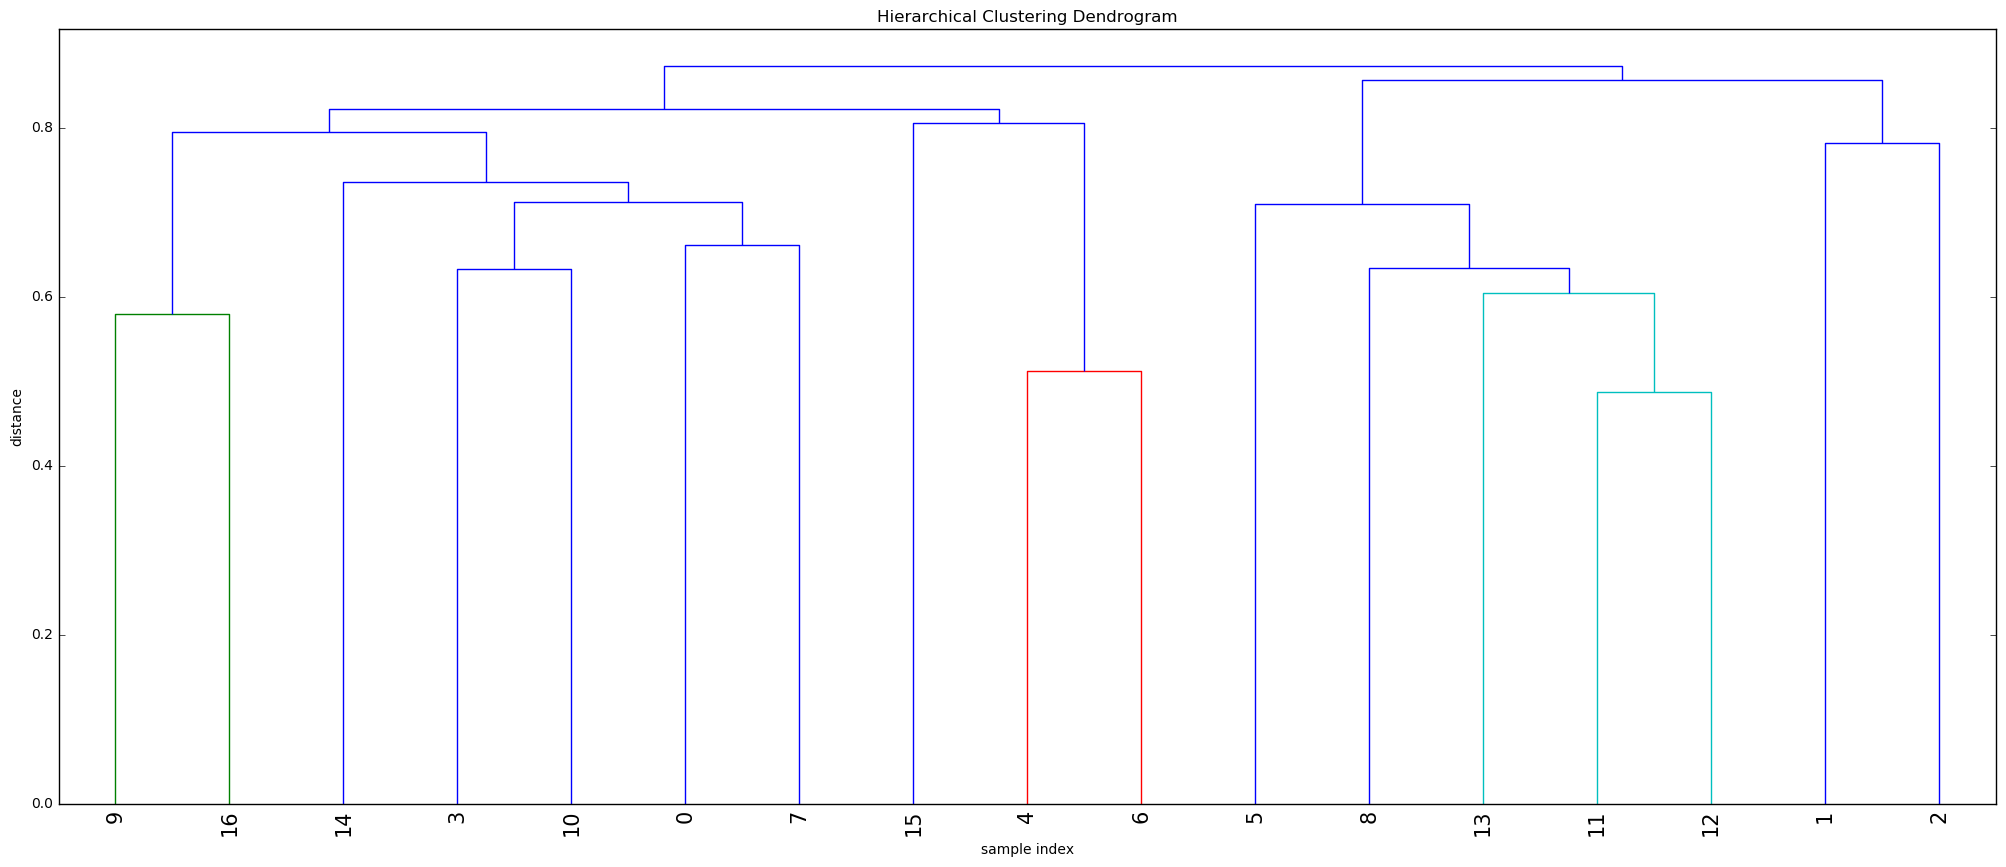

id| True | Pred | Sentence
 0 | 0    | 1    | `` but if UNK want a good price for UNK , UNK be go to have to sell a big chunk of UNK .
 1 | 1    | 2    | `` this be someone whose primary duty be to respond to emergency , who will have a vehicle assign to UNK , who will have the ability to make command decision and summon more senior people if necessary , '' say joseph e. hofmann , senior vice president in charge of subway .
 2 | 1    | 2    | giuliani say that be `` action that UNK think be very very useful . ''
 3 | 0    | 1    | standard life say UNK be concern the investment in bank of scotland amount to 900 million pound ( $ 1.37 billion ) or 6 percent of the group 's u.k. equity portfolio , which UNK say be too large for a single investment .
 4 | 0    | 1    | some 9.7 million share be trade , compare with the daily average of 2.3 million .
 5 | 1    | 2    | mayor rudolph giuliani have complain that while senior police and fire official reach the 51st street station soon after e

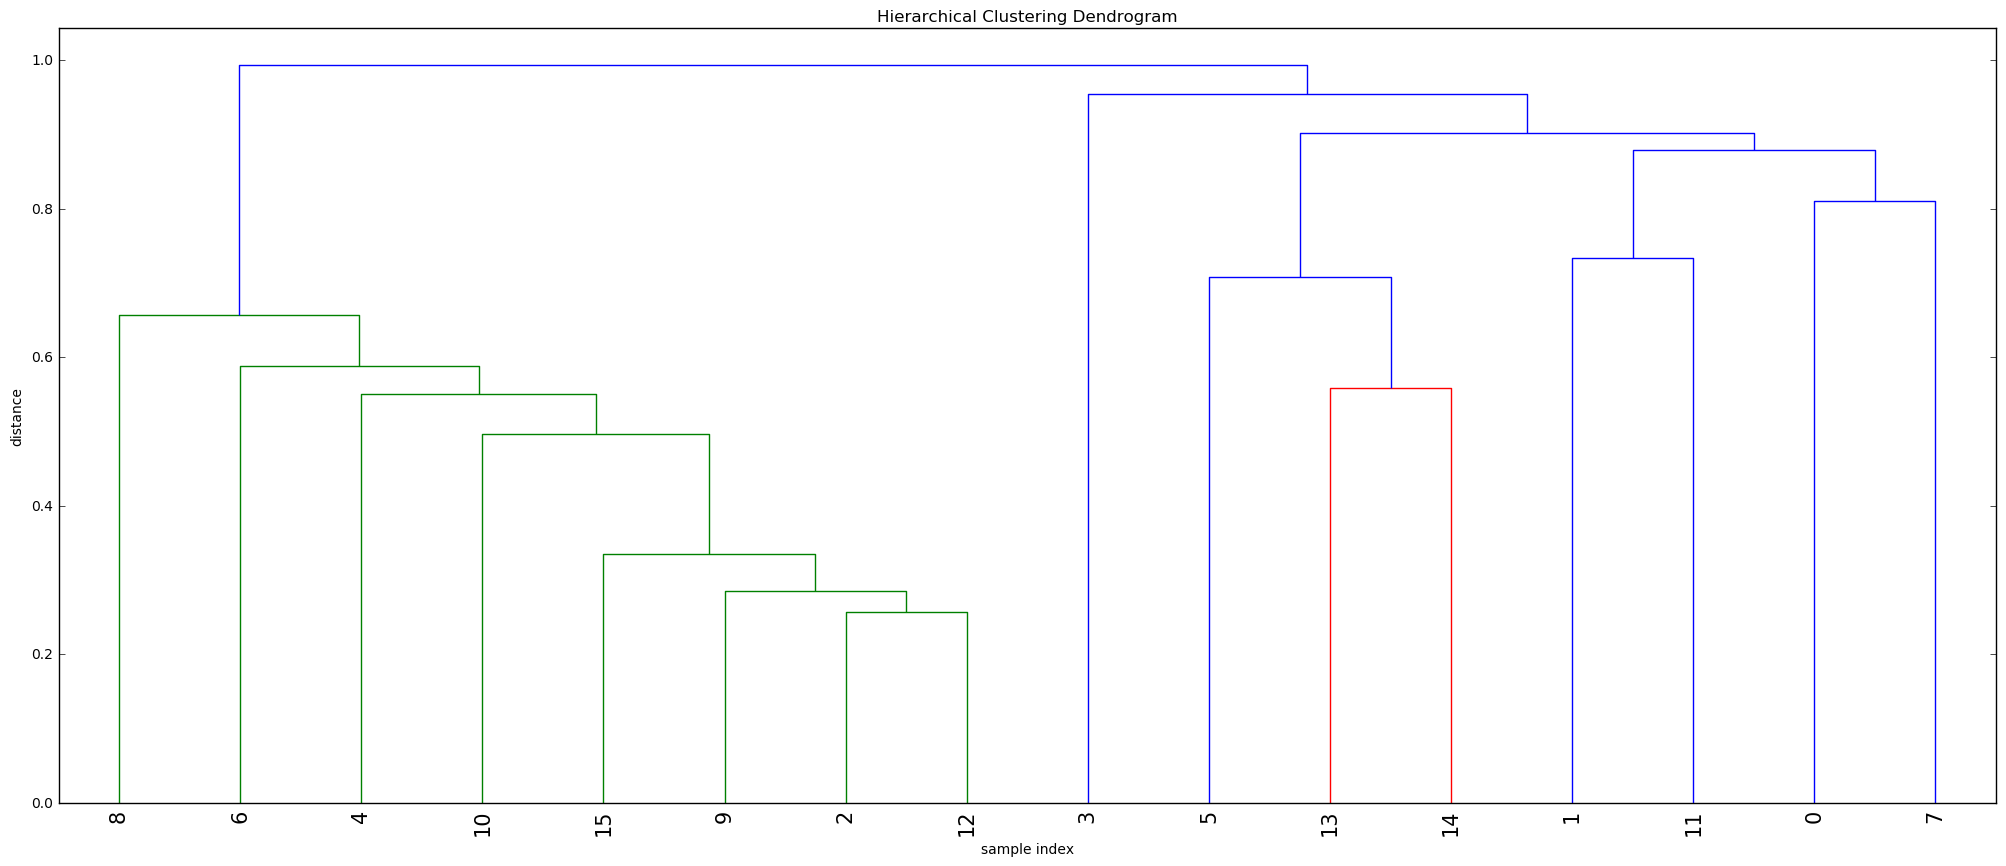

id| True | Pred | Sentence
 0 | 0    | 2    | 2 ) walk off from behind counter when more than 25 people be in line .
 1 | 0    | 2    | 3 ) argue on phone with boyfriend regard result on do - UNK - UNK pregnancy test .
 2 | 1    | 1    | esto articulo proceden de clarin , el diario mas prestigioso de argentina , y de la circulacion mayor en el mundo de habla espanola .
 3 | 0    | 2    | bill UNK of venice , UNK , make a list :
 4 | 1    | 1    | esta son las notas de clarin transmitida hoy :
 5 | 0    | 2    | judge by the response , convenience store clerk rank right up there with serial killer and journalist in term of public esteem .
 6 | 1    | 1    | unos investigador UNK su cabana alli y siguen la ruta a su muerte .
 7 | 0    | 2    | 1 ) never give a direct answer on how long ago the deli sub be make .
 8 | 1    | 1    | leyenda : buscando a butch y sundance .
 9 | 1    | 1    | se transmiten en espanol tre articulo UNK , cubriendo los tema de la politica , las art y literatura

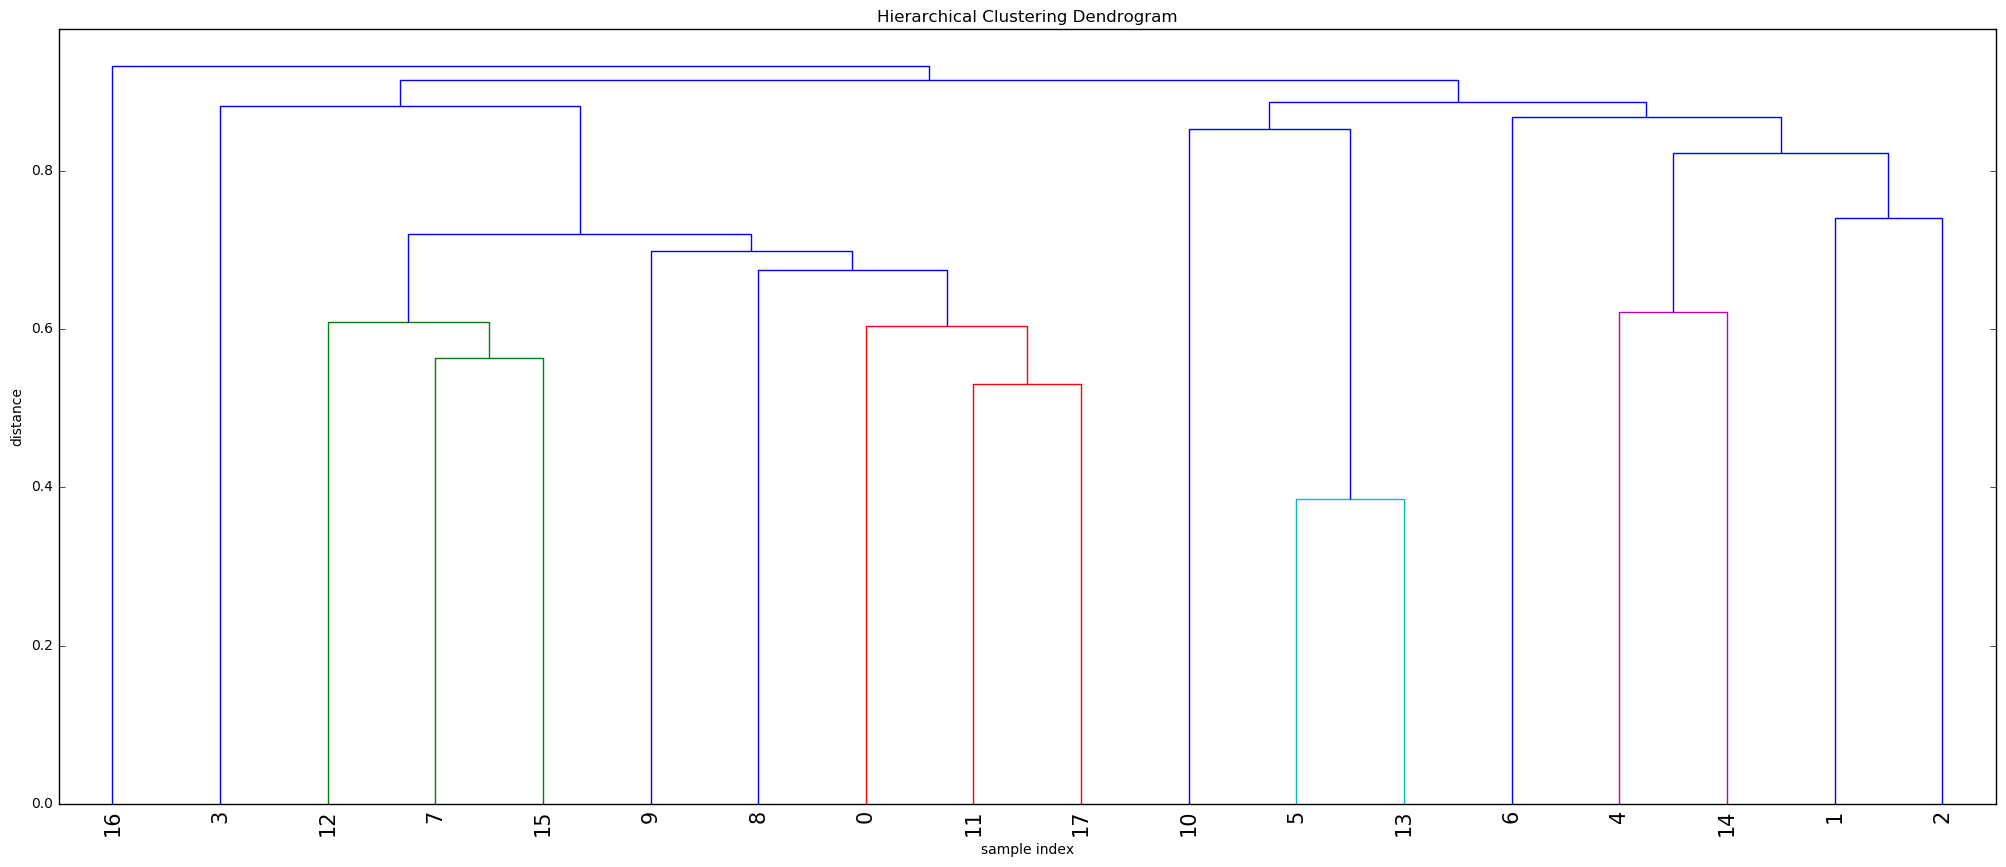

id| True | Pred | Sentence
 0 | 1    | 1    | but UNK present a challenge : how to make back - up copy of all that datum in case the computer crash while on the road .
 1 | 0    | 1    | on this side of the field be lehman brothers .
 2 | 0    | 1    | but last year shearson lehman split up , and while lehman retain right to the list -- ten uncommon value -- smith barney , which get shearson , feel heir to the tradition , too .
 3 | 0    | 1    | the disparity be not unusual .
 4 | 0    | 1    | every july since 1949 , lehman have offer up a list of 10 good stock for the next 12 month .
 5 | 0    | 1    | in 1990 , these list ' 7.25 percent loss trail the s&p 500 's loss of 3.1 percent , but UNK total return of 50 percent in 1991 , 20.24 percent in 1992 and 19.6 in 1993 consistently outdo the 500 's respective return of 30.5 percent , 7.6 percent and 10.1 percent .
 6 | 0    | 1    | so in july UNK suit up a rival portfolio -- ten exceptional names -- and friday end the new contest 's 

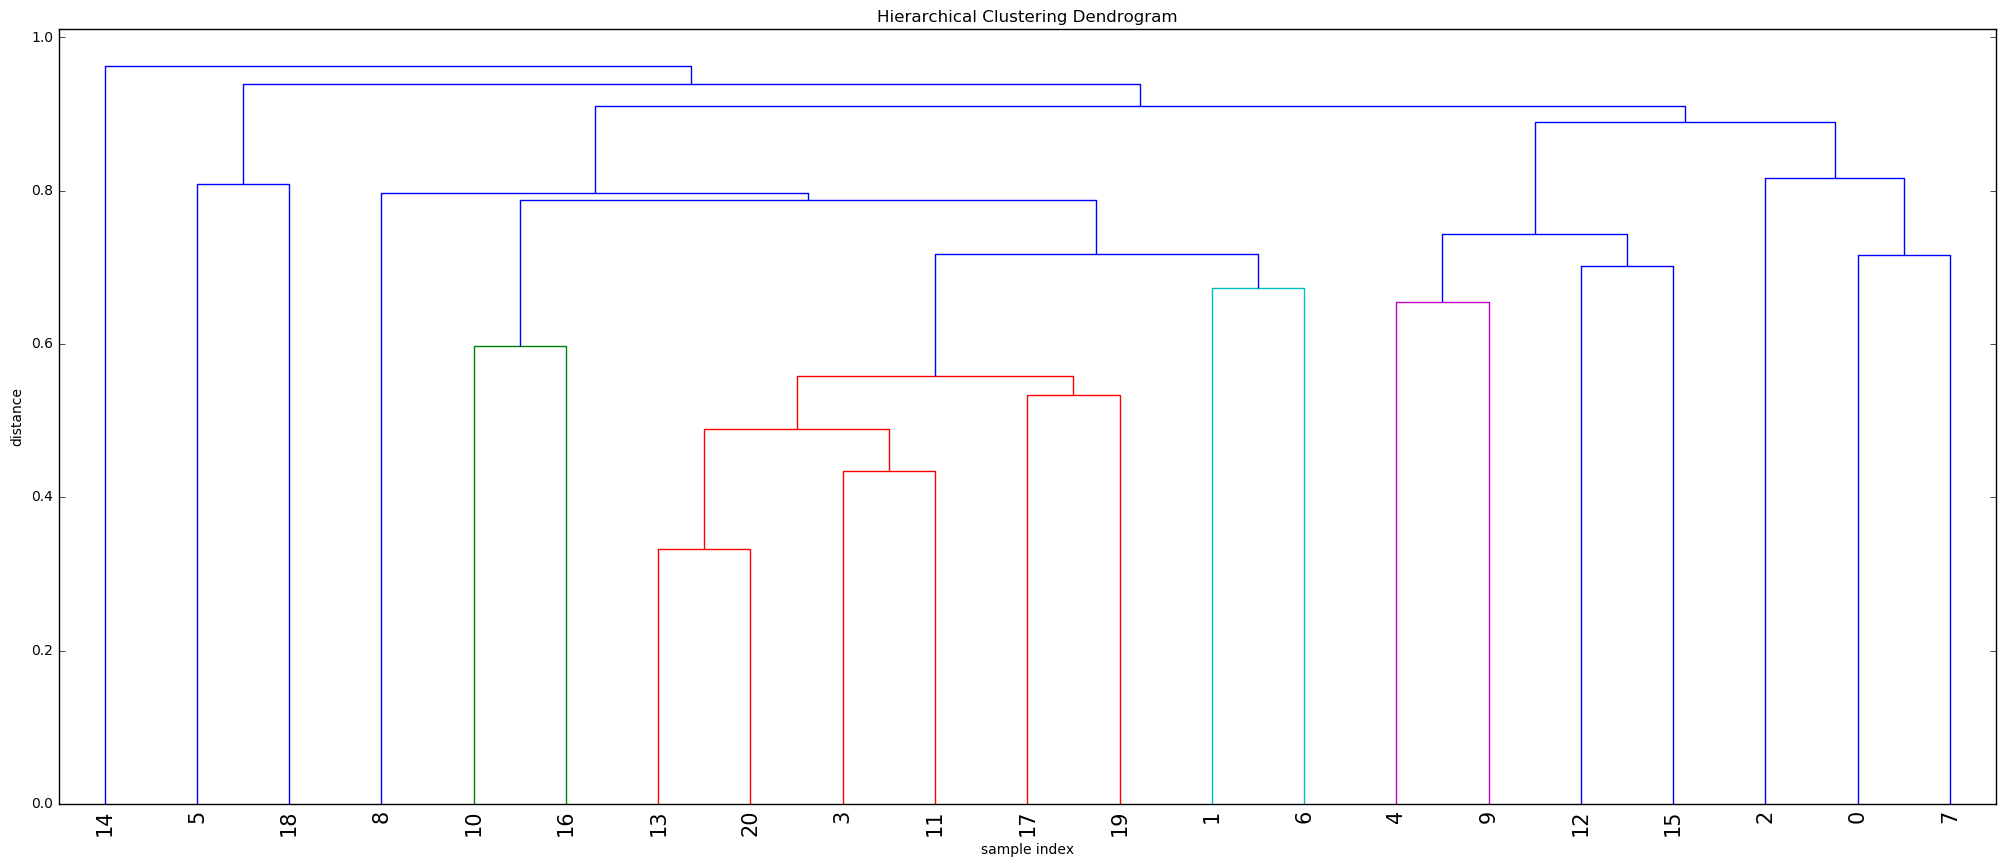

id| True | Pred | Sentence
 0 | 1    | 1    | four day after st. john 's startled sixth - rank georgetown in an impressive 83 - 72 conquest at madison square garden , the red storm walk onto the same court and become sleep walker in the first half wednesday night .
 1 | 0    | 1    | and the chicago bulls have a great chance to win UNK fourth nba championship since 1991 as a result .
 2 | 1    | 1    | many of the UNK fan who witness the shoddy performance boo st. john 's early in the second half .
 3 | 0    | 1    | when the bulls make the trade for rodman with the san antonio spurs UNK have to bring haley in as well .
 4 | 1    | 1    | can the red storm stumble much low ?
 5 | 1    | 1    | a frenetic comeback fall short and only make the result more UNK .
 6 | 0    | 1    | for one thing dennis the menace 's presence on the bulls divert plenty of attention from jordan , who really would rather do without UNK .
 7 | 1    | 1    | in a season of disappointing loss and depressing deve

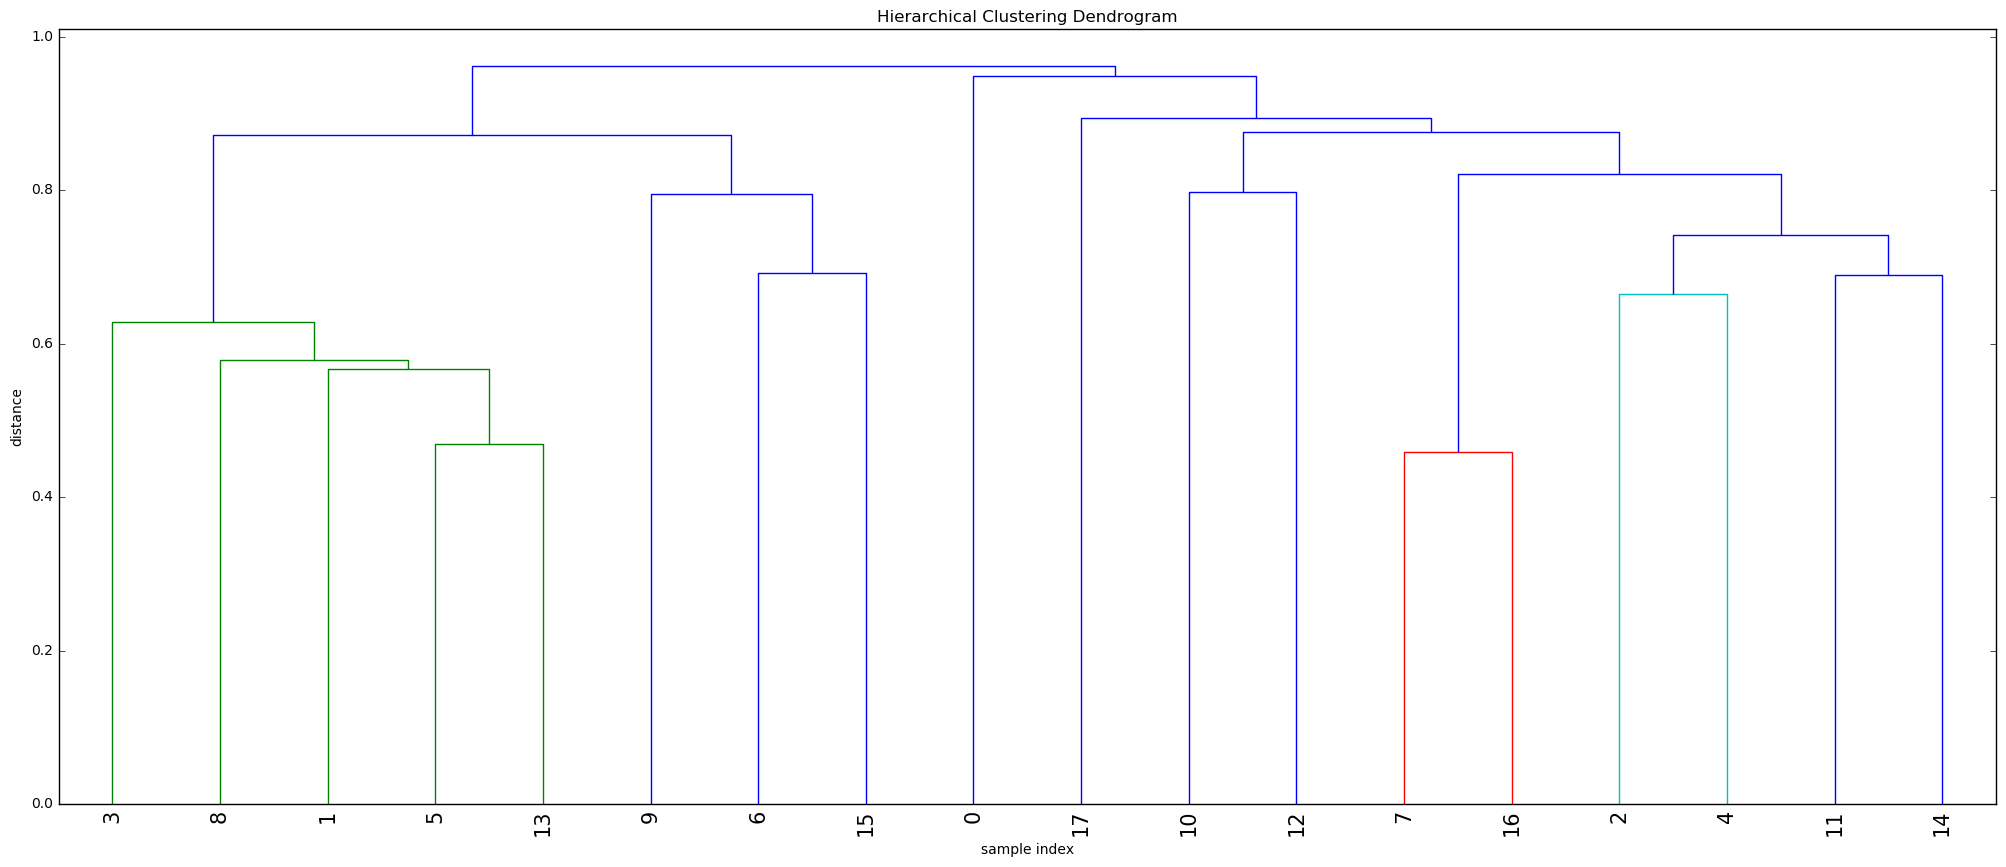

id| True | Pred | Sentence
 0 | 0    | 2    | UNK consume UNK .
 1 | 1    | 1    | in UNK first meeting since obuchi take office in july , clinton seek publicly to assure the japanese of the premium the united states place on UNK relationship with japan , where more than 40,000 u.s. troop , pilot and sailor be base to help safeguard u.s. security interest in east asia .
 2 | 0    | 2    | pat mitchell , 55 , be now president of cnn productions and time inc. .
 3 | 1    | 1    | and , with the u.s. trade deficit with japan mushroom , clinton ask obuchi to develop , within two week , a plan for open five key sector of the economy -- telecommunication , pharmaceutical , energy , housing and construction -- to increase import competition .
 4 | 0    | 2    | UNK profile reach an apex sunday with the debut of `` cold war , '' the colossal 24-hour documentary that ted turner envision , then turn over to mitchell .
 5 | 1    | 1    | clinton invite obuchi to a state visit at the white house s

In [31]:
for _ in range(20):
    demo_evaluation(scdv)
    print('\n')